In [1]:
# Copyright 2019 The Authors. All Rights Reserved.
#
# GNU General Public License v3.0
# Permissions of this strongest copyleft license are conditioned on 
# making available complete source code of licensed works and modifications, 
# which include larger works using a licensed work, under the same license. 
# Copyright and license notices must be preserved. 
# Contributors provide an express grant of patent rights. 
# When a modified version is used to provide a service over a network, 
# the complete source code of the modified version must be made available.
# ==============================================================================

# Title: Clustering of CRISPR spacers using Autoencoders
# Author: Hyunjin Shim
# Date created: 20190813
# Email: jinenstar@hotmail.com

# Clustering CRISPR spacers using Autoencoders

- to analyze CRISPR spacers/units from https://crispi.genouest.org/
- to cluster CRISPR spacers/units by type
- to perform dimensionality reduction to identify patterns
- to visualize the results after each experimentation
- to assess the best possible network architecture

# Dataset description
- Archaea: 15591 spacers
- Bacteria 67838 spacers

# Step 1: Load and preprocess raw data

In [2]:
# Data
import os
import pandas as pd
import numpy as np

# Biopython
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

# Regular expression
import re

# Plot
from pylab import *
import pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
import matplotlib.patches as mpatches

# Tensorflow
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers

# sklearn
from sklearn.model_selection import train_test_split


env: OPENBLAS_NUM_THREADS=6
env: OMP_NUM_THREADS=6
env: MKL_NUM_THREADS=6
env: NUMEXPR_NUM_THREADS=6


Using TensorFlow backend.


In [3]:
# location of raw data file
datapath = '/Users/jinenstar/Desktop/Data/CRISPR'
os.chdir(datapath)

# use Biopython to process and parse sequences
file_in ='archaea_spacer.txt'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_ar_spacer = []
    all_sequence_ar_spacer = []
    all_length_ar_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        # remove .id from .description record (remove all before first space)
        #seq_record.description=' '.join(seq_record.description.split()[1:])
        # a list of IDs and sequences
        all_ID_ar_spacer.append(seq_record.id)
        all_sequence_ar_spacer.append(seq_record.seq)
        all_length_ar_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_ar_spacer = max(all_length_ar_spacer)
min_length_ar_spacer = min(all_length_ar_spacer)

In [4]:
print(seq_record)

ID: ref|NC_014537|
Name: ref|NC_014537|
Description: ref|NC_014537|  Vulcanisaeta distributa DSM 14429 chromosome 1601737-1601789
Number of features: 0
Seq('GCCGGCCCAGACTCATGTTACTGCAAACTCGAGGGGATTGGGTGCACGCAGAT', SingleLetterAlphabet())


In [5]:
print(min_length_ar_spacer)
print(all_length_ar_spacer.index(min_length_ar_spacer))
#all_ID[all_length_ar_spacer.index(min_length_ar_spacer)]

4
11232


In [6]:
print(max_length_ar_spacer)
print(all_length_ar_spacer.index(max_length_ar_spacer))
#all_ID_ar_spacer[all_length_ar_spacer.index(max_length_ar_spacer)]

488
5094


In [7]:
all_ID_ar_spacer[-10:]

['ref|NC_014537|',
 'ref|NC_014537|',
 'ref|NC_014537|',
 'ref|NC_014537|',
 'ref|NC_014537|',
 'ref|NC_014537|',
 'ref|NC_014537|',
 'ref|NC_014537|',
 'ref|NC_014537|',
 'ref|NC_014537|']

In [8]:
all_sequence_ar_spacer[-10:]

[Seq('TAAAGCAGTCTATCAAGCATTCCGTGATTTCCTTAAGGAAAG', SingleLetterAlphabet()),
 Seq('AAAGATGGTGCCAGTATTGCCAGGCAATGAAATTCATGATGGTTT', SingleLetterAlphabet()),
 Seq('AATACAATAATAAGAGTCCCTGCGGACCCTAACGGTAAGCCGACAG', SingleLetterAlphabet()),
 Seq('TACTGTGAATGCGTTGAATGTCAACACAGCTACTTACCAGCAAA', SingleLetterAlphabet()),
 Seq('TCAGTAGTCATTATGATGTACTGCCAGACGGCCATTCCCCTATTGT', SingleLetterAlphabet()),
 Seq('GTGTCTAAAAATGACGATGCATGTGAGTGGTTTAAGGCGTGGTTGACA', SingleLetterAlphabet()),
 Seq('TCGTTAAAAGATACGGGGCAGGAAATAATGACATTTGAAGAGGGATTA', SingleLetterAlphabet()),
 Seq('ATTCCTAATCACCTACACCTCAAATTCGCAGGTAATGGAATAACTTCG', SingleLetterAlphabet()),
 Seq('AAAAACTTATAAATCAGTCCTGAGCAAAAACAATGTATGAAAGAAA', SingleLetterAlphabet()),
 Seq('GCCGGCCCAGACTCATGTTACTGCAAACTCGAGGGGATTGGGTGCACGCAGAT', SingleLetterAlphabet())]

In [9]:
# location of raw data file
datapath = '/Users/jinenstar/Desktop/Data/CRISPR'
os.chdir(datapath)

# use Biopython to process and parse sequences
file_in ='bacteria_spacer.txt'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_ba_spacer = []
    all_sequence_ba_spacer = []
    all_length_ba_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        # remove .id from .description record (remove all before first space)
        #seq_record.description=' '.join(seq_record.description.split()[1:])
        # a list of IDs and sequences
        all_ID_ba_spacer.append(seq_record.id)
        all_sequence_ba_spacer.append(seq_record.seq)
        all_length_ba_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_ba_spacer = max(all_length_ba_spacer)
min_length_ba_spacer = min(all_length_ba_spacer)

In [10]:
print(seq_record)

ID: ref|NC_022900|
Name: ref|NC_022900|
Description: ref|NC_022900|  Zymomonas mobilis subsp. mobilis str. CP4 = NRRL B-14023 1794820-1794851
Number of features: 0
Seq('GCCAATTTTTCAGCATAACGTCGCAGCTCAAC', SingleLetterAlphabet())


In [11]:
print(min_length_ba_spacer)
print(all_length_ba_spacer.index(min_length_ba_spacer))
#all_ID_ba_spacer[all_length_ba_spacer.index(min_length_ba_spacer)]

2
47107


In [12]:
print(max_length_ba_spacer)
print(all_length_ba_spacer.index(max_length_ba_spacer))
#all_ID_ba_spacer[all_length_ba_spacer.index(max_length_ba_spacer)]

946
65581


In [13]:
all_ID_ba_spacer[-10:]

['ref|NC_022900|',
 'ref|NC_022900|',
 'ref|NC_022900|',
 'ref|NC_022900|',
 'ref|NC_022900|',
 'ref|NC_022900|',
 'ref|NC_022900|',
 'ref|NC_022900|',
 'ref|NC_022900|',
 'ref|NC_022900|']

In [14]:
all_sequence_ba_spacer[-10:]

[Seq('CGACCGTTACGATCAACGATATCGGCGCGCGCCTGCAACGGCGCAACGGGTGGA...GTG', SingleLetterAlphabet()),
 Seq('GAAGGATTTTTGCCCGGGACAAAAT', SingleLetterAlphabet()),
 Seq('CAGCTTTGCGCTTTAGCGTTGCGG', SingleLetterAlphabet()),
 Seq('CTCCAAGAAGAGATCGCAACCGAG', SingleLetterAlphabet()),
 Seq('AAAAGACACGATATGCGATGTGGC', SingleLetterAlphabet()),
 Seq('GCGTGTCTTCGATAATAACTCTGCGACGATC', SingleLetterAlphabet()),
 Seq('CGACAGTCGGGCCGGATACCATGATCCGAGT', SingleLetterAlphabet()),
 Seq('AAGGTAATATTATCGTCACTGACAAGCAAGG', SingleLetterAlphabet()),
 Seq('TCTTGTGACATTGCTGGCTTTGCTTGAGCAT', SingleLetterAlphabet()),
 Seq('GCCAATTTTTCAGCATAACGTCGCAGCTCAAC', SingleLetterAlphabet())]

In [15]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_ar_spacer = []
for i in range(len(all_sequence_ar_spacer)):
    all_sequence_no_ar_spacer.append(str(all_sequence_ar_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0'))

In [16]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_ba_spacer = []
for i in range(len(all_sequence_ba_spacer)):
    all_sequence_no_ba_spacer.append(str(all_sequence_ba_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('B','0').replace('H','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0'))

In [17]:
all_sequence_no = all_sequence_no_ar_spacer + all_sequence_no_ba_spacer

In [18]:
# dictionary to DataFrame
all_ID = all_ID_ar_spacer + all_ID_ba_spacer
all_length = all_length_ar_spacer + all_length_ba_spacer

all_label_ar_spacer = [0] * len(all_sequence_ar_spacer)
all_label_ba_spacer = [1] * len(all_sequence_ba_spacer)
all_label = all_label_ar_spacer + all_label_ba_spacer

all_keyword_ar_spacer = ['Archaea'] * len(all_sequence_ar_spacer)
all_keyword_ba_spacer = ['Bacteria'] * len(all_sequence_ba_spacer)
all_keyword = all_keyword_ar_spacer + all_keyword_ba_spacer

d = {'ID':all_ID, 'Category':all_keyword, 'Label':all_label, 'Length':all_length}
all_data = pd.DataFrame(d)

In [19]:
all_data

,ID,Category,Label,Length
0,ref|NC_015518|,Archaea,0,33
1,ref|NC_015518|,Archaea,0,35
2,ref|NC_015518|,Archaea,0,35
3,ref|NC_015518|,Archaea,0,34
4,ref|NC_015518|,Archaea,0,36
5,ref|NC_015518|,Archaea,0,34
6,ref|NC_015518|,Archaea,0,34
7,ref|NC_015518|,Archaea,0,35
8,ref|NC_015518|,Archaea,0,34
9,ref|NC_015518|,Archaea,0,34


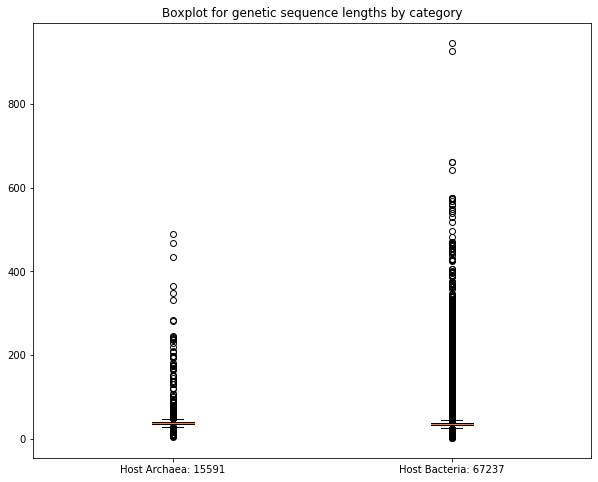

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

data_archaea = all_data[all_data['Label']==0]
len_archaea = len(data_archaea)
data_bacteria = all_data[all_data['Label']==1]
len_bacteria = len(data_bacteria)

# boxplot
data_plot = [data_archaea['Length'],data_bacteria['Length']]
fig1, ax1 = plt.subplots(figsize=(10,8))
ax1.set_title('Boxplot for genetic sequence lengths by category')
ax1.boxplot(data_plot)
plt.xticks([1,2],['Host Archaea: '+str(len_archaea),'Host Bacteria: '+str(len_bacteria)])
plt.show()

In [21]:
# numpy array of sequences of a fixed length

median_length = 50
# define numpy array with dimension (1,227,759 proteins, median=500 features)
all_sequence_no_dim = np.zeros(shape=(len(all_sequence_no),median_length))
# define dimension of features
no_dim_features = median_length

print(all_sequence_no_dim.shape)

for n in range(len(all_sequence_no)):
    # convert char sequence to digit sequence
    sequence_digits=[int(d) for d in str(all_sequence_no[n])]
    # store digit sequence into numpy with right dimension
    if len(sequence_digits) <= median_length:
        all_sequence_no_dim[n,0:len(sequence_digits)]=sequence_digits[0:len(sequence_digits)]
    else:
        all_sequence_no_dim[n]=sequence_digits[0:median_length]   

(82828, 50)


In [22]:
# print(all_sequence[0])
# print(all_sequence_no[0])
# print(len(all_sequence_no_dim[0]))
# print(all_sequence_no_dim[0])

In [23]:
def reproduce(seed_number):
    import tensorflow as tf
    import random
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(seed_number)
    random.seed(seed_number)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    #from keras import backend as K
    tf.set_random_seed(seed_number)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    #K.set_session(sess)
    tf.keras.backend.set_session(sess)

In [24]:
from sklearn.preprocessing import MinMaxScaler
#scale data 0-1
min_max_scaler = MinMaxScaler( feature_range=(0,1), copy=True )
all_sequence_no_dim_norm = min_max_scaler.fit_transform(all_sequence_no_dim)

In [25]:
# what type of gene subpopulations exist in data? Let's do PCA
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=2)
Y = pca.fit_transform(all_sequence_no_dim_norm)
#Y = pca.fit_transform(all_sequence_no_dim)

# 3D PCA
pca_3D = PCA(n_components=3)
Y_3D = pca.fit_transform(all_sequence_no_dim_norm)

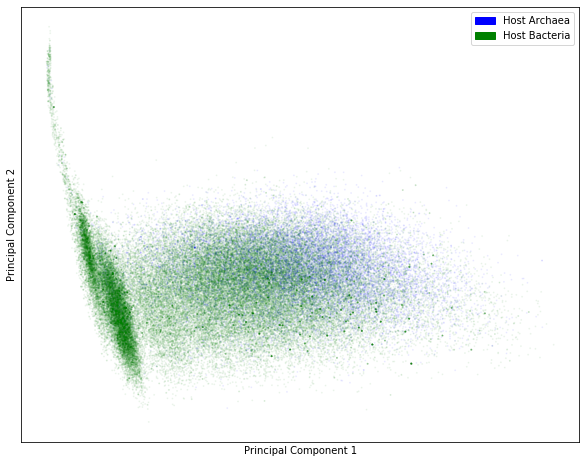

In [26]:
#label_name = {1:"Host Archaea", 2:"Host Bacteria"}
label_color_map = {0:'blue',1:'green'}
label_color = [label_color_map[c] for c in all_label]

# 2D PCA plot
fig = plt.figure(figsize=(10,8))
ax = plt.scatter(Y[:,0], Y[:,1], s=1, c=label_color, alpha=0.05)

plt.xticks([])
plt.yticks([])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
virus_patch = mpatches.Patch(color='blue', label='Host Archaea')
phage_patch = mpatches.Patch(color='green', label='Host Bacteria')
plt.legend(handles=[virus_patch,phage_patch],loc='upper right')

plt.show()
#fig.savefig('PCA_min_features_acr_2D.pdf')

# Step 2: Create, compile, fit autoencoder model
- use Keras, a high-level neural networks API that runs on top of librares like TensorFlow.

In [27]:
#split the data in training and test sets
Y = pd.Series(all_label)

x_train, x_test, y_train_og, y_test = train_test_split(all_sequence_no_dim_norm, Y, test_size=0.01, random_state=10)
print('Training set has', x_train.shape[0], 'rows and', x_train.shape[1], 'columns')
print('Test set has', x_test.shape[0], 'rows and', x_test.shape[1], 'columns')

Training set has 81999 rows and 50 columns
Test set has 829 rows and 50 columns


In [28]:
y_train = pd.Series(y_train_og).values

In [29]:
#plot original data, reconstructed data, residuals
def plot_reconstruction(data_norm, data_dec):
    plt.figure(figsize=(30,20))
    plt.subplot(3,1,1)
    ax1 = plt.imshow(data_norm, cmap="seismic", aspect="auto", vmin=0, vmax=1)
    cbar = plt.colorbar(ax1)
    plt.title('Original data', fontsize=25)
    plt.subplot(3,1,2)
    ax2 = plt.imshow(data_dec, cmap="seismic", aspect="auto", vmin=0, vmax=1)
    cbar = plt.colorbar(ax2)
    plt.title('Recondstruction', fontsize=25)
    plt.subplot(3,1,3)
    ax3 = plt.imshow(data_norm-data_dec, cmap="seismic", aspect="auto", vmin=-1, vmax=1)
    plt.gca().set_xticks(range(no_dim_features))
#    plt.gca().set_xticklabels(markers, fontsize=20)
    cbar = plt.colorbar(ax3)
    plt.title('Residuals', fontsize=25)
    plt.show()
    # print residual values
    print(sum(abs(data_norm-data_dec)))
    
#plot training history
def plot_history(autoencoder):
    fig = plt.figure(figsize=(6,4))
    plt.plot(autoencoder.history.history['loss'])
    plt.plot(autoencoder.history.history['val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss function')
    plt.legend(['Loss', 'Validation loss'])
    plt.show()

#plot reduced dimensions
def plot_encoded(x_train_encoded, y_train): 
    #label_name = {1:"Host Archaea", 2:"Host Bacteria"}
    label_color_map = {0:'blue',1:'green'}
    label_color = [label_color_map[c] for c in y_train]

    virus_patch = mpatches.Patch(color='blue', label='Host Archaea')
    phage_patch = mpatches.Patch(color='green', label='Host Bacteria')

    fig = plt.figure(figsize=(10,8))
    ax = plt.scatter(x_train_encoded[:,0], x_train_encoded[:,1], s=5, c=label_color, alpha=0.05)
    #cbar = plt.colorbar(ax, ticks=range(21))
    #cbar.ax.set_yticklabels(cell_types['cell type name'])
    #ax.set_facecolor('white')

    plt.legend(handles=[virus_patch,phage_patch],loc='upper right')

    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()

def plot_encoded_3D(x_train_encoded, y_train):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111, projection='3d')

    label_color_map = {0:'blue',1:'green'}
    label_color = [label_color_map[c] for c in y_train]
    
    ax.scatter(x_train_encoded[:,0], \
               x_train_encoded[:,1], \
               x_train_encoded[:,2], \
               c=label_color, alpha=0.1)

    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')
    ax.set_zlabel('Dim 3')
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    pylab.title("3D Embedding: ")
    pylab.show()
    return

In [95]:
reproduce(10)

#set dimensions of input and hidden layer
input_dim = no_dim_features
intermediate_1 = 40
intermediate_2 = 30
intermediate_3 = 20
intermediate_4 = 10
latent_dim = 3

input_data = tf.keras.layers.Input(shape=(input_dim,))
#encode the input with a dense layer
encoded_1 = tf.keras.layers.Dense(intermediate_1, activation='relu')(input_data)
encoded_2 = tf.keras.layers.Dense(intermediate_2, activation='relu')(encoded_1)
encoded_3 = tf.keras.layers.Dense(intermediate_3, activation='relu')(encoded_2)
encoded_4 = tf.keras.layers.Dense(intermediate_4, activation='relu')(encoded_3)
encoded_5 = tf.keras.layers.Dense(latent_dim, activation='relu')(encoded_4)
#decode the encoded input to its reconstruction
decoded_1 = tf.keras.layers.Dense(intermediate_4, activation='relu')(encoded_5)
decoded_2 = tf.keras.layers.Dense(intermediate_3, activation='relu')(decoded_1)
decoded_3 = tf.keras.layers.Dense(intermediate_2, activation='relu')(decoded_2)
decoded_4 = tf.keras.layers.Dense(intermediate_1, activation='relu')(decoded_3)
decoded_5 = tf.keras.layers.Dense(input_dim, activation='sigmoid')(decoded_4)

#autoencoder_2 maps the input to the output
autoencoder_5 = tf.keras.models.Model(input_data, decoded_5)

#encoder_2 maps the input to the latent representation
encoder_5 = tf.keras.models.Model(input_data, encoded_5)

#compile the model and set the desired optimizer and loss function
adam = tf.keras.optimizers.Adam(lr=0.0000001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder_5.compile(optimizer=adam, loss='mean_squared_error')
autoencoder_5.summary()
autoencoder_5.fit(x_train, x_train,
                epochs=10000,
                batch_size=256,
                shuffle=False,
                validation_data=(x_test, x_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 50)                0         
_________________________________________________________________
dense_120 (Dense)            (None, 40)                2040      
_________________________________________________________________
dense_121 (Dense)            (None, 30)                1230      
_________________________________________________________________
dense_122 (Dense)            (None, 20)                620       
_________________________________________________________________
dense_123 (Dense)            (None, 10)                210       
_________________________________________________________________
dense_124 (Dense)            (None, 3)                 33        
_________________________________________________________________
dense_125 (Dense)            (None, 10)                40        
__________

81999/81999 [==============================] - 1s 16us/sample - loss: 0.1364 - val_loss: 0.1364
Epoch 59/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.1364 - val_loss: 0.1364
Epoch 60/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1364 - val_loss: 0.1364
Epoch 61/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1364 - val_loss: 0.1364
Epoch 62/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1364 - val_loss: 0.1364
Epoch 63/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1364 - val_loss: 0.1364
Epoch 64/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1364 - val_loss: 0.1364
Epoch 65/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1363 - val_loss: 0.1364
Epoch 66/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1363 - val_loss: 0.1364
Epoch 67/10000
8

81999/81999 [==============================] - 1s 11us/sample - loss: 0.1359 - val_loss: 0.1359
Epoch 132/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1358 - val_loss: 0.1359
Epoch 133/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1358 - val_loss: 0.1359
Epoch 134/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1358 - val_loss: 0.1359
Epoch 135/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1358 - val_loss: 0.1358
Epoch 136/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1358 - val_loss: 0.1358
Epoch 137/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1358 - val_loss: 0.1358
Epoch 138/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1358 - val_loss: 0.1358
Epoch 139/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1358 - val_loss: 0.1358
Epoch 14

81999/81999 [==============================] - 1s 11us/sample - loss: 0.1351 - val_loss: 0.1351
Epoch 205/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1351 - val_loss: 0.1351
Epoch 206/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1351 - val_loss: 0.1351
Epoch 207/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1351 - val_loss: 0.1351
Epoch 208/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1351 - val_loss: 0.1351
Epoch 209/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1350 - val_loss: 0.1351
Epoch 210/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1350 - val_loss: 0.1351
Epoch 211/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1350 - val_loss: 0.1350
Epoch 212/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1350 - val_loss: 0.1350
Epoch 21

81999/81999 [==============================] - 1s 11us/sample - loss: 0.1341 - val_loss: 0.1341
Epoch 278/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1341 - val_loss: 0.1341
Epoch 279/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1341 - val_loss: 0.1341
Epoch 280/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1341 - val_loss: 0.1341
Epoch 281/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1340 - val_loss: 0.1340
Epoch 282/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1340 - val_loss: 0.1340
Epoch 283/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.1340 - val_loss: 0.1340
Epoch 284/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1340 - val_loss: 0.1340
Epoch 285/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.1340 - val_loss: 0.1340
Epoch 28

81999/81999 [==============================] - 1s 11us/sample - loss: 0.1328 - val_loss: 0.1328
Epoch 351/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1328 - val_loss: 0.1328
Epoch 352/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1328 - val_loss: 0.1328
Epoch 353/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1328 - val_loss: 0.1328
Epoch 354/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1327 - val_loss: 0.1327
Epoch 355/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1327 - val_loss: 0.1327
Epoch 356/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1327 - val_loss: 0.1327
Epoch 357/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1327 - val_loss: 0.1327
Epoch 358/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1327 - val_loss: 0.1327
Epoch 35

81999/81999 [==============================] - 1s 11us/sample - loss: 0.1312 - val_loss: 0.1312
Epoch 424/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1312 - val_loss: 0.1312
Epoch 425/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1312 - val_loss: 0.1312
Epoch 426/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1311 - val_loss: 0.1311
Epoch 427/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1311 - val_loss: 0.1311
Epoch 428/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1311 - val_loss: 0.1311
Epoch 429/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1311 - val_loss: 0.1311
Epoch 430/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1311 - val_loss: 0.1310
Epoch 431/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1310 - val_loss: 0.1310
Epoch 43

81999/81999 [==============================] - 1s 11us/sample - loss: 0.1293 - val_loss: 0.1293
Epoch 497/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1292 - val_loss: 0.1292
Epoch 498/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1292 - val_loss: 0.1292
Epoch 499/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1292 - val_loss: 0.1292
Epoch 500/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1292 - val_loss: 0.1291
Epoch 501/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1291 - val_loss: 0.1291
Epoch 502/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1291 - val_loss: 0.1291
Epoch 503/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1291 - val_loss: 0.1290
Epoch 504/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1290 - val_loss: 0.1290
Epoch 50

81999/81999 [==============================] - 1s 11us/sample - loss: 0.1269 - val_loss: 0.1269
Epoch 570/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1269 - val_loss: 0.1268
Epoch 571/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1268 - val_loss: 0.1268
Epoch 572/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1268 - val_loss: 0.1268
Epoch 573/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1268 - val_loss: 0.1267
Epoch 574/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1267 - val_loss: 0.1267
Epoch 575/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1267 - val_loss: 0.1267
Epoch 576/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1267 - val_loss: 0.1266
Epoch 577/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1266 - val_loss: 0.1266
Epoch 57

81999/81999 [==============================] - 1s 11us/sample - loss: 0.1241 - val_loss: 0.1240
Epoch 643/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1241 - val_loss: 0.1240
Epoch 644/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1240 - val_loss: 0.1240
Epoch 645/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1240 - val_loss: 0.1239
Epoch 646/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1239 - val_loss: 0.1239
Epoch 647/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1239 - val_loss: 0.1238
Epoch 648/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1238 - val_loss: 0.1238
Epoch 649/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1238 - val_loss: 0.1237
Epoch 650/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1238 - val_loss: 0.1237
Epoch 65

81999/81999 [==============================] - 1s 11us/sample - loss: 0.1209 - val_loss: 0.1208
Epoch 716/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1208 - val_loss: 0.1207
Epoch 717/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1208 - val_loss: 0.1207
Epoch 718/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1207 - val_loss: 0.1206
Epoch 719/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1207 - val_loss: 0.1206
Epoch 720/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1206 - val_loss: 0.1205
Epoch 721/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1206 - val_loss: 0.1205
Epoch 722/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1205 - val_loss: 0.1205
Epoch 723/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1205 - val_loss: 0.1204
Epoch 72

81999/81999 [==============================] - 1s 11us/sample - loss: 0.1172 - val_loss: 0.1171
Epoch 789/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1172 - val_loss: 0.1171
Epoch 790/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1171 - val_loss: 0.1170
Epoch 791/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1171 - val_loss: 0.1170
Epoch 792/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.1170 - val_loss: 0.1169
Epoch 793/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1170 - val_loss: 0.1169
Epoch 794/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1169 - val_loss: 0.1168
Epoch 795/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1169 - val_loss: 0.1168
Epoch 796/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1168 - val_loss: 0.1167
Epoch 79

81999/81999 [==============================] - 1s 11us/sample - loss: 0.1133 - val_loss: 0.1132
Epoch 862/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1132 - val_loss: 0.1131
Epoch 863/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1132 - val_loss: 0.1130
Epoch 864/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1131 - val_loss: 0.1130
Epoch 865/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1131 - val_loss: 0.1129
Epoch 866/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1130 - val_loss: 0.1129
Epoch 867/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1130 - val_loss: 0.1128
Epoch 868/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1129 - val_loss: 0.1128
Epoch 869/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1129 - val_loss: 0.1127
Epoch 87

81999/81999 [==============================] - 1s 11us/sample - loss: 0.1092 - val_loss: 0.1090
Epoch 935/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1091 - val_loss: 0.1090
Epoch 936/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1091 - val_loss: 0.1089
Epoch 937/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1090 - val_loss: 0.1089
Epoch 938/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1090 - val_loss: 0.1088
Epoch 939/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1089 - val_loss: 0.1087
Epoch 940/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1089 - val_loss: 0.1087
Epoch 941/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1088 - val_loss: 0.1086
Epoch 942/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1088 - val_loss: 0.1086
Epoch 94

81999/81999 [==============================] - 1s 11us/sample - loss: 0.1051 - val_loss: 0.1049
Epoch 1008/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1050 - val_loss: 0.1048
Epoch 1009/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1050 - val_loss: 0.1048
Epoch 1010/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1049 - val_loss: 0.1047
Epoch 1011/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1049 - val_loss: 0.1047
Epoch 1012/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.1048 - val_loss: 0.1046
Epoch 1013/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1048 - val_loss: 0.1045
Epoch 1014/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1047 - val_loss: 0.1045
Epoch 1015/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1047 - val_loss: 0.1044


81999/81999 [==============================] - 1s 11us/sample - loss: 0.1011 - val_loss: 0.1009
Epoch 1080/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1011 - val_loss: 0.1008
Epoch 1081/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1010 - val_loss: 0.1008
Epoch 1082/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1010 - val_loss: 0.1007
Epoch 1083/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1009 - val_loss: 0.1007
Epoch 1084/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1008 - val_loss: 0.1006
Epoch 1085/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1008 - val_loss: 0.1006
Epoch 1086/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1007 - val_loss: 0.1005
Epoch 1087/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.1007 - val_loss: 0.1004


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0973 - val_loss: 0.0970
Epoch 1152/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0972 - val_loss: 0.0970
Epoch 1153/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0972 - val_loss: 0.0969
Epoch 1154/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0971 - val_loss: 0.0969
Epoch 1155/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0971 - val_loss: 0.0968
Epoch 1156/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0970 - val_loss: 0.0968
Epoch 1157/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0970 - val_loss: 0.0967
Epoch 1158/10000
81999/81999 [==============================] - 1s 14us/sample - loss: 0.0969 - val_loss: 0.0967
Epoch 1159/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0969 - val_loss: 0.0966


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0937 - val_loss: 0.0934
Epoch 1224/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0937 - val_loss: 0.0934
Epoch 1225/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0936 - val_loss: 0.0933
Epoch 1226/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0936 - val_loss: 0.0933
Epoch 1227/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0935 - val_loss: 0.0932
Epoch 1228/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0935 - val_loss: 0.0932
Epoch 1229/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0934 - val_loss: 0.0931
Epoch 1230/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0934 - val_loss: 0.0931
Epoch 1231/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0933 - val_loss: 0.0930


81999/81999 [==============================] - 1s 14us/sample - loss: 0.0904 - val_loss: 0.0901
Epoch 1296/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0903 - val_loss: 0.0900
Epoch 1297/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0903 - val_loss: 0.0900
Epoch 1298/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0902 - val_loss: 0.0899
Epoch 1299/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0902 - val_loss: 0.0899
Epoch 1300/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0901 - val_loss: 0.0898
Epoch 1301/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0901 - val_loss: 0.0898
Epoch 1302/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0900 - val_loss: 0.0898
Epoch 1303/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0900 - val_loss: 0.0897


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0874 - val_loss: 0.0871
Epoch 1368/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0873 - val_loss: 0.0870
Epoch 1369/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0873 - val_loss: 0.0870
Epoch 1370/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0872 - val_loss: 0.0870
Epoch 1371/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0872 - val_loss: 0.0869
Epoch 1372/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0872 - val_loss: 0.0869
Epoch 1373/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0871 - val_loss: 0.0869
Epoch 1374/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0871 - val_loss: 0.0868
Epoch 1375/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0871 - val_loss: 0.0868


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0847 - val_loss: 0.0845
Epoch 1440/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0847 - val_loss: 0.0844
Epoch 1441/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0847 - val_loss: 0.0844
Epoch 1442/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0846 - val_loss: 0.0844
Epoch 1443/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0846 - val_loss: 0.0843
Epoch 1444/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0846 - val_loss: 0.0843
Epoch 1445/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0845 - val_loss: 0.0843
Epoch 1446/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0845 - val_loss: 0.0842
Epoch 1447/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0845 - val_loss: 0.0842


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0825 - val_loss: 0.0822
Epoch 1512/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0824 - val_loss: 0.0822
Epoch 1513/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0824 - val_loss: 0.0822
Epoch 1514/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0824 - val_loss: 0.0821
Epoch 1515/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0823 - val_loss: 0.0821
Epoch 1516/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0823 - val_loss: 0.0821
Epoch 1517/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0823 - val_loss: 0.0821
Epoch 1518/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0822 - val_loss: 0.0820
Epoch 1519/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0822 - val_loss: 0.0820


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0805 - val_loss: 0.0803
Epoch 1584/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0804 - val_loss: 0.0802
Epoch 1585/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0804 - val_loss: 0.0802
Epoch 1586/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0804 - val_loss: 0.0802
Epoch 1587/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0803 - val_loss: 0.0802
Epoch 1588/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0803 - val_loss: 0.0801
Epoch 1589/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0803 - val_loss: 0.0801
Epoch 1590/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0803 - val_loss: 0.0801
Epoch 1591/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0802 - val_loss: 0.0801


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0787 - val_loss: 0.0785
Epoch 1656/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0787 - val_loss: 0.0785
Epoch 1657/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0786 - val_loss: 0.0785
Epoch 1658/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0786 - val_loss: 0.0785
Epoch 1659/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0786 - val_loss: 0.0784
Epoch 1660/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0786 - val_loss: 0.0784
Epoch 1661/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0786 - val_loss: 0.0784
Epoch 1662/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0785 - val_loss: 0.0784
Epoch 1663/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0785 - val_loss: 0.0783


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0771 - val_loss: 0.0770
Epoch 1728/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0771 - val_loss: 0.0770
Epoch 1729/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0771 - val_loss: 0.0769
Epoch 1730/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0771 - val_loss: 0.0769
Epoch 1731/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0771 - val_loss: 0.0769
Epoch 1732/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0770 - val_loss: 0.0769
Epoch 1733/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0770 - val_loss: 0.0769
Epoch 1734/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0770 - val_loss: 0.0768
Epoch 1735/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0770 - val_loss: 0.0768


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0757 - val_loss: 0.0756
Epoch 1800/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0757 - val_loss: 0.0756
Epoch 1801/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0757 - val_loss: 0.0756
Epoch 1802/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0757 - val_loss: 0.0755
Epoch 1803/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0757 - val_loss: 0.0755
Epoch 1804/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0756 - val_loss: 0.0755
Epoch 1805/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0756 - val_loss: 0.0755
Epoch 1806/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0756 - val_loss: 0.0755
Epoch 1807/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0756 - val_loss: 0.0754


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0745 - val_loss: 0.0743
Epoch 1872/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0745 - val_loss: 0.0743
Epoch 1873/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0744 - val_loss: 0.0743
Epoch 1874/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0744 - val_loss: 0.0743
Epoch 1875/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0744 - val_loss: 0.0743
Epoch 1876/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0744 - val_loss: 0.0742
Epoch 1877/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0744 - val_loss: 0.0742
Epoch 1878/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0744 - val_loss: 0.0742
Epoch 1879/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0743 - val_loss: 0.0742


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0733 - val_loss: 0.0732
Epoch 1944/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0733 - val_loss: 0.0731
Epoch 1945/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0733 - val_loss: 0.0731
Epoch 1946/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0733 - val_loss: 0.0731
Epoch 1947/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0733 - val_loss: 0.0731
Epoch 1948/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0732 - val_loss: 0.0731
Epoch 1949/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0732 - val_loss: 0.0731
Epoch 1950/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0732 - val_loss: 0.0730
Epoch 1951/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0732 - val_loss: 0.0730


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0723 - val_loss: 0.0721
Epoch 2016/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0723 - val_loss: 0.0721
Epoch 2017/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0722 - val_loss: 0.0721
Epoch 2018/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0722 - val_loss: 0.0720
Epoch 2019/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0722 - val_loss: 0.0720
Epoch 2020/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0722 - val_loss: 0.0720
Epoch 2021/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0722 - val_loss: 0.0720
Epoch 2022/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0722 - val_loss: 0.0720
Epoch 2023/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0722 - val_loss: 0.0720


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0713 - val_loss: 0.0711
Epoch 2088/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0713 - val_loss: 0.0711
Epoch 2089/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0713 - val_loss: 0.0711
Epoch 2090/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0713 - val_loss: 0.0711
Epoch 2091/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0713 - val_loss: 0.0710
Epoch 2092/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0713 - val_loss: 0.0710
Epoch 2093/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0712 - val_loss: 0.0710
Epoch 2094/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0712 - val_loss: 0.0710
Epoch 2095/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0712 - val_loss: 0.0710


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0704 - val_loss: 0.0702
Epoch 2160/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0704 - val_loss: 0.0702
Epoch 2161/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0704 - val_loss: 0.0702
Epoch 2162/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0704 - val_loss: 0.0702
Epoch 2163/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0704 - val_loss: 0.0701
Epoch 2164/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0704 - val_loss: 0.0701
Epoch 2165/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0704 - val_loss: 0.0701
Epoch 2166/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0704 - val_loss: 0.0701
Epoch 2167/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0704 - val_loss: 0.0701


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0697 - val_loss: 0.0694
Epoch 2232/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0696 - val_loss: 0.0694
Epoch 2233/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0696 - val_loss: 0.0694
Epoch 2234/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0696 - val_loss: 0.0694
Epoch 2235/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0696 - val_loss: 0.0693
Epoch 2236/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0696 - val_loss: 0.0693
Epoch 2237/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0696 - val_loss: 0.0693
Epoch 2238/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0696 - val_loss: 0.0693
Epoch 2239/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0696 - val_loss: 0.0693


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0690 - val_loss: 0.0687
Epoch 2304/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0689 - val_loss: 0.0687
Epoch 2305/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0689 - val_loss: 0.0686
Epoch 2306/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0689 - val_loss: 0.0686
Epoch 2307/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0689 - val_loss: 0.0686
Epoch 2308/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0689 - val_loss: 0.0686
Epoch 2309/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0689 - val_loss: 0.0686
Epoch 2310/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0689 - val_loss: 0.0686
Epoch 2311/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0689 - val_loss: 0.0686


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0683 - val_loss: 0.0680
Epoch 2376/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0683 - val_loss: 0.0680
Epoch 2377/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0683 - val_loss: 0.0680
Epoch 2378/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0683 - val_loss: 0.0680
Epoch 2379/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0683 - val_loss: 0.0680
Epoch 2380/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0683 - val_loss: 0.0680
Epoch 2381/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0683 - val_loss: 0.0680
Epoch 2382/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0683 - val_loss: 0.0680
Epoch 2383/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0683 - val_loss: 0.0680


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0678 - val_loss: 0.0675
Epoch 2448/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0678 - val_loss: 0.0675
Epoch 2449/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0678 - val_loss: 0.0675
Epoch 2450/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0678 - val_loss: 0.0674
Epoch 2451/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0678 - val_loss: 0.0674
Epoch 2452/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0678 - val_loss: 0.0674
Epoch 2453/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0678 - val_loss: 0.0674
Epoch 2454/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0678 - val_loss: 0.0674
Epoch 2455/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0678 - val_loss: 0.0674


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0674 - val_loss: 0.0670
Epoch 2520/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0673 - val_loss: 0.0670
Epoch 2521/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0673 - val_loss: 0.0670
Epoch 2522/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0673 - val_loss: 0.0670
Epoch 2523/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0673 - val_loss: 0.0670
Epoch 2524/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0673 - val_loss: 0.0670
Epoch 2525/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0673 - val_loss: 0.0670
Epoch 2526/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0673 - val_loss: 0.0670
Epoch 2527/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0673 - val_loss: 0.0670


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0670 - val_loss: 0.0666
Epoch 2592/10000
81999/81999 [==============================] - 1s 14us/sample - loss: 0.0670 - val_loss: 0.0666
Epoch 2593/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0670 - val_loss: 0.0666
Epoch 2594/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0669 - val_loss: 0.0666
Epoch 2595/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0669 - val_loss: 0.0666
Epoch 2596/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0669 - val_loss: 0.0666
Epoch 2597/10000
81999/81999 [==============================] - 1s 14us/sample - loss: 0.0669 - val_loss: 0.0666
Epoch 2598/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0669 - val_loss: 0.0666
Epoch 2599/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0669 - val_loss: 0.0666


81999/81999 [==============================] - 1s 14us/sample - loss: 0.0666 - val_loss: 0.0663
Epoch 2664/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0666 - val_loss: 0.0663
Epoch 2665/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0666 - val_loss: 0.0663
Epoch 2666/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0666 - val_loss: 0.0663
Epoch 2667/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0666 - val_loss: 0.0663
Epoch 2668/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0666 - val_loss: 0.0663
Epoch 2669/10000
81999/81999 [==============================] - 1s 14us/sample - loss: 0.0666 - val_loss: 0.0663
Epoch 2670/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0666 - val_loss: 0.0662
Epoch 2671/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0666 - val_loss: 0.0662


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0663 - val_loss: 0.0660
Epoch 2736/10000
81999/81999 [==============================] - 1s 14us/sample - loss: 0.0663 - val_loss: 0.0660
Epoch 2737/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0663 - val_loss: 0.0660
Epoch 2738/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0663 - val_loss: 0.0660
Epoch 2739/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0663 - val_loss: 0.0660
Epoch 2740/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0663 - val_loss: 0.0660
Epoch 2741/10000
81999/81999 [==============================] - 1s 10us/sample - loss: 0.0663 - val_loss: 0.0660
Epoch 2742/10000
81999/81999 [==============================] - 1s 10us/sample - loss: 0.0663 - val_loss: 0.0660
Epoch 2743/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0663 - val_loss: 0.0660


81999/81999 [==============================] - 1s 13us/sample - loss: 0.0661 - val_loss: 0.0657
Epoch 2808/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0661 - val_loss: 0.0657
Epoch 2809/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0661 - val_loss: 0.0657
Epoch 2810/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0661 - val_loss: 0.0657
Epoch 2811/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0661 - val_loss: 0.0657
Epoch 2812/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0661 - val_loss: 0.0657
Epoch 2813/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0661 - val_loss: 0.0657
Epoch 2814/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0661 - val_loss: 0.0657
Epoch 2815/10000
81999/81999 [==============================] - 1s 15us/sample - loss: 0.0661 - val_loss: 0.0657


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0659 - val_loss: 0.0655
Epoch 2880/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0659 - val_loss: 0.0655
Epoch 2881/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0659 - val_loss: 0.0655
Epoch 2882/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0659 - val_loss: 0.0655
Epoch 2883/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0659 - val_loss: 0.0655
Epoch 2884/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0659 - val_loss: 0.0655
Epoch 2885/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0659 - val_loss: 0.0655
Epoch 2886/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0659 - val_loss: 0.0655
Epoch 2887/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0659 - val_loss: 0.0655


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0657 - val_loss: 0.0653
Epoch 2952/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0657 - val_loss: 0.0653
Epoch 2953/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0657 - val_loss: 0.0653
Epoch 2954/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0657 - val_loss: 0.0653
Epoch 2955/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0657 - val_loss: 0.0653
Epoch 2956/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0657 - val_loss: 0.0653
Epoch 2957/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0657 - val_loss: 0.0653
Epoch 2958/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0657 - val_loss: 0.0653
Epoch 2959/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0657 - val_loss: 0.0653


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0656 - val_loss: 0.0652
Epoch 3024/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0656 - val_loss: 0.0652
Epoch 3025/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0656 - val_loss: 0.0652
Epoch 3026/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0656 - val_loss: 0.0652
Epoch 3027/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0656 - val_loss: 0.0652
Epoch 3028/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0656 - val_loss: 0.0652
Epoch 3029/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0656 - val_loss: 0.0651
Epoch 3030/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0656 - val_loss: 0.0651
Epoch 3031/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0656 - val_loss: 0.0651


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0654 - val_loss: 0.0650
Epoch 3096/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0654 - val_loss: 0.0650
Epoch 3097/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0654 - val_loss: 0.0650
Epoch 3098/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0654 - val_loss: 0.0650
Epoch 3099/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0654 - val_loss: 0.0650
Epoch 3100/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0654 - val_loss: 0.0650
Epoch 3101/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0654 - val_loss: 0.0650
Epoch 3102/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0654 - val_loss: 0.0650
Epoch 3103/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0654 - val_loss: 0.0649


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0652 - val_loss: 0.0648
Epoch 3168/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0652 - val_loss: 0.0648
Epoch 3169/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0652 - val_loss: 0.0648
Epoch 3170/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0652 - val_loss: 0.0648
Epoch 3171/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0652 - val_loss: 0.0648
Epoch 3172/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0652 - val_loss: 0.0648
Epoch 3173/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0652 - val_loss: 0.0648
Epoch 3174/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0652 - val_loss: 0.0648
Epoch 3175/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0652 - val_loss: 0.0648


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0651 - val_loss: 0.0646
Epoch 3240/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0651 - val_loss: 0.0646
Epoch 3241/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0651 - val_loss: 0.0646
Epoch 3242/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0651 - val_loss: 0.0646
Epoch 3243/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0651 - val_loss: 0.0646
Epoch 3244/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0651 - val_loss: 0.0646
Epoch 3245/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0651 - val_loss: 0.0646
Epoch 3246/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0651 - val_loss: 0.0646
Epoch 3247/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0651 - val_loss: 0.0646


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0649 - val_loss: 0.0645
Epoch 3312/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0649 - val_loss: 0.0645
Epoch 3313/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0649 - val_loss: 0.0645
Epoch 3314/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0649 - val_loss: 0.0645
Epoch 3315/10000
81999/81999 [==============================] - 1s 9us/sample - loss: 0.0649 - val_loss: 0.0645
Epoch 3316/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0649 - val_loss: 0.0645
Epoch 3317/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0649 - val_loss: 0.0645
Epoch 3318/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0649 - val_loss: 0.0645
Epoch 3319/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0649 - val_loss: 0.0645
E

81999/81999 [==============================] - 1s 12us/sample - loss: 0.0648 - val_loss: 0.0643
Epoch 3384/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0648 - val_loss: 0.0643
Epoch 3385/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0648 - val_loss: 0.0643
Epoch 3386/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0648 - val_loss: 0.0643
Epoch 3387/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0648 - val_loss: 0.0643
Epoch 3388/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0648 - val_loss: 0.0643
Epoch 3389/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0648 - val_loss: 0.0643
Epoch 3390/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0648 - val_loss: 0.0643
Epoch 3391/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0648 - val_loss: 0.0643


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0646 - val_loss: 0.0642
Epoch 3456/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0646 - val_loss: 0.0642
Epoch 3457/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0646 - val_loss: 0.0642
Epoch 3458/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0646 - val_loss: 0.0642
Epoch 3459/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0646 - val_loss: 0.0642
Epoch 3460/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0646 - val_loss: 0.0642
Epoch 3461/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0646 - val_loss: 0.0642
Epoch 3462/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0646 - val_loss: 0.0642
Epoch 3463/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0646 - val_loss: 0.0642


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0645 - val_loss: 0.0640
Epoch 3528/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0645 - val_loss: 0.0640
Epoch 3529/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0645 - val_loss: 0.0640
Epoch 3530/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0645 - val_loss: 0.0640
Epoch 3531/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0645 - val_loss: 0.0640
Epoch 3532/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0645 - val_loss: 0.0640
Epoch 3533/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0645 - val_loss: 0.0640
Epoch 3534/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0645 - val_loss: 0.0640
Epoch 3535/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0645 - val_loss: 0.0640


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0643 - val_loss: 0.0639
Epoch 3600/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0643 - val_loss: 0.0639
Epoch 3601/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0643 - val_loss: 0.0639
Epoch 3602/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0643 - val_loss: 0.0639
Epoch 3603/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0643 - val_loss: 0.0639
Epoch 3604/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0643 - val_loss: 0.0639
Epoch 3605/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0643 - val_loss: 0.0639
Epoch 3606/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0643 - val_loss: 0.0639
Epoch 3607/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0643 - val_loss: 0.0639


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0642 - val_loss: 0.0637
Epoch 3672/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0642 - val_loss: 0.0637
Epoch 3673/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0642 - val_loss: 0.0637
Epoch 3674/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0642 - val_loss: 0.0637
Epoch 3675/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0642 - val_loss: 0.0637
Epoch 3676/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0642 - val_loss: 0.0637
Epoch 3677/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0642 - val_loss: 0.0637
Epoch 3678/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0642 - val_loss: 0.0637
Epoch 3679/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0642 - val_loss: 0.0637


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0640 - val_loss: 0.0635
Epoch 3744/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0640 - val_loss: 0.0635
Epoch 3745/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0640 - val_loss: 0.0635
Epoch 3746/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0640 - val_loss: 0.0635
Epoch 3747/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0640 - val_loss: 0.0635
Epoch 3748/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0640 - val_loss: 0.0635
Epoch 3749/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0640 - val_loss: 0.0635
Epoch 3750/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0640 - val_loss: 0.0635
Epoch 3751/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0640 - val_loss: 0.0635


81999/81999 [==============================] - 1s 13us/sample - loss: 0.0639 - val_loss: 0.0634
Epoch 3816/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0639 - val_loss: 0.0634
Epoch 3817/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0639 - val_loss: 0.0634
Epoch 3818/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0639 - val_loss: 0.0634
Epoch 3819/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0639 - val_loss: 0.0634
Epoch 3820/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0638 - val_loss: 0.0634
Epoch 3821/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0638 - val_loss: 0.0634
Epoch 3822/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0638 - val_loss: 0.0634
Epoch 3823/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0638 - val_loss: 0.0634


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0637 - val_loss: 0.0632
Epoch 3888/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0637 - val_loss: 0.0632
Epoch 3889/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0637 - val_loss: 0.0632
Epoch 3890/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0637 - val_loss: 0.0632
Epoch 3891/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0637 - val_loss: 0.0632
Epoch 3892/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0637 - val_loss: 0.0632
Epoch 3893/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0637 - val_loss: 0.0632
Epoch 3894/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0637 - val_loss: 0.0632
Epoch 3895/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0637 - val_loss: 0.0632


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0635 - val_loss: 0.0631
Epoch 3960/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0635 - val_loss: 0.0631
Epoch 3961/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0635 - val_loss: 0.0631
Epoch 3962/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0635 - val_loss: 0.0630
Epoch 3963/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0635 - val_loss: 0.0630
Epoch 3964/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0635 - val_loss: 0.0630
Epoch 3965/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0635 - val_loss: 0.0630
Epoch 3966/10000
81999/81999 [==============================] - 1s 16us/sample - loss: 0.0635 - val_loss: 0.0630
Epoch 3967/10000
81999/81999 [==============================] - 1s 14us/sample - loss: 0.0635 - val_loss: 0.0630


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0634 - val_loss: 0.0629
Epoch 4032/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0634 - val_loss: 0.0629
Epoch 4033/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0634 - val_loss: 0.0629
Epoch 4034/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0634 - val_loss: 0.0629
Epoch 4035/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0634 - val_loss: 0.0629
Epoch 4036/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0634 - val_loss: 0.0629
Epoch 4037/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0634 - val_loss: 0.0629
Epoch 4038/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0633 - val_loss: 0.0629
Epoch 4039/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0633 - val_loss: 0.0629


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0631 - val_loss: 0.0626
Epoch 4104/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0631 - val_loss: 0.0626
Epoch 4105/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0631 - val_loss: 0.0626
Epoch 4106/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0631 - val_loss: 0.0626
Epoch 4107/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0631 - val_loss: 0.0626
Epoch 4108/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0631 - val_loss: 0.0626
Epoch 4109/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0631 - val_loss: 0.0626
Epoch 4110/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0631 - val_loss: 0.0626
Epoch 4111/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0631 - val_loss: 0.0626


81999/81999 [==============================] - 1s 13us/sample - loss: 0.0629 - val_loss: 0.0624
Epoch 4176/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0629 - val_loss: 0.0624
Epoch 4177/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0629 - val_loss: 0.0624
Epoch 4178/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0629 - val_loss: 0.0624
Epoch 4179/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0629 - val_loss: 0.0624
Epoch 4180/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0629 - val_loss: 0.0624
Epoch 4181/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0629 - val_loss: 0.0624
Epoch 4182/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0629 - val_loss: 0.0624
Epoch 4183/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0629 - val_loss: 0.0624


81999/81999 [==============================] - 1s 13us/sample - loss: 0.0627 - val_loss: 0.0623
Epoch 4248/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0627 - val_loss: 0.0623
Epoch 4249/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0627 - val_loss: 0.0623
Epoch 4250/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0627 - val_loss: 0.0623
Epoch 4251/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0627 - val_loss: 0.0622
Epoch 4252/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0627 - val_loss: 0.0622
Epoch 4253/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0627 - val_loss: 0.0622
Epoch 4254/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0627 - val_loss: 0.0622
Epoch 4255/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0627 - val_loss: 0.0622


81999/81999 [==============================] - 1s 13us/sample - loss: 0.0626 - val_loss: 0.0621
Epoch 4320/10000
81999/81999 [==============================] - 1s 14us/sample - loss: 0.0625 - val_loss: 0.0621
Epoch 4321/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0625 - val_loss: 0.0621
Epoch 4322/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0625 - val_loss: 0.0621
Epoch 4323/10000
81999/81999 [==============================] - 1s 14us/sample - loss: 0.0625 - val_loss: 0.0621
Epoch 4324/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0625 - val_loss: 0.0621
Epoch 4325/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0625 - val_loss: 0.0621
Epoch 4326/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0625 - val_loss: 0.0621
Epoch 4327/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0625 - val_loss: 0.0621


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0624 - val_loss: 0.0619
Epoch 4392/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0624 - val_loss: 0.0619
Epoch 4393/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0624 - val_loss: 0.0619
Epoch 4394/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0624 - val_loss: 0.0619
Epoch 4395/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0624 - val_loss: 0.0619
Epoch 4396/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0624 - val_loss: 0.0619
Epoch 4397/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0624 - val_loss: 0.0619
Epoch 4398/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0624 - val_loss: 0.0619
Epoch 4399/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0623 - val_loss: 0.0619


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0622 - val_loss: 0.0617
Epoch 4464/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0622 - val_loss: 0.0617
Epoch 4465/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0622 - val_loss: 0.0617
Epoch 4466/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0622 - val_loss: 0.0617
Epoch 4467/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0622 - val_loss: 0.0617
Epoch 4468/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0622 - val_loss: 0.0617
Epoch 4469/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0622 - val_loss: 0.0617
Epoch 4470/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0622 - val_loss: 0.0617
Epoch 4471/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0622 - val_loss: 0.0617


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0620 - val_loss: 0.0616
Epoch 4536/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0620 - val_loss: 0.0615
Epoch 4537/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0620 - val_loss: 0.0615
Epoch 4538/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0620 - val_loss: 0.0615
Epoch 4539/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0620 - val_loss: 0.0615
Epoch 4540/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0620 - val_loss: 0.0615
Epoch 4541/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0620 - val_loss: 0.0615
Epoch 4542/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0620 - val_loss: 0.0615
Epoch 4543/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0620 - val_loss: 0.0615


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0618 - val_loss: 0.0614
Epoch 4608/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0618 - val_loss: 0.0614
Epoch 4609/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0618 - val_loss: 0.0614
Epoch 4610/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0618 - val_loss: 0.0614
Epoch 4611/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0618 - val_loss: 0.0614
Epoch 4612/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0618 - val_loss: 0.0614
Epoch 4613/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0618 - val_loss: 0.0614
Epoch 4614/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0618 - val_loss: 0.0614
Epoch 4615/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0618 - val_loss: 0.0614


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0617 - val_loss: 0.0612
Epoch 4680/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0617 - val_loss: 0.0612
Epoch 4681/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0617 - val_loss: 0.0612
Epoch 4682/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0617 - val_loss: 0.0612
Epoch 4683/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0617 - val_loss: 0.0612
Epoch 4684/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0617 - val_loss: 0.0612
Epoch 4685/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0617 - val_loss: 0.0612
Epoch 4686/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0617 - val_loss: 0.0612
Epoch 4687/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0617 - val_loss: 0.0612


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0615 - val_loss: 0.0611
Epoch 4752/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0615 - val_loss: 0.0611
Epoch 4753/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0615 - val_loss: 0.0611
Epoch 4754/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0615 - val_loss: 0.0611
Epoch 4755/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0615 - val_loss: 0.0611
Epoch 4756/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0615 - val_loss: 0.0610
Epoch 4757/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0615 - val_loss: 0.0610
Epoch 4758/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0615 - val_loss: 0.0610
Epoch 4759/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0615 - val_loss: 0.0610


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0613 - val_loss: 0.0609
Epoch 4824/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0613 - val_loss: 0.0609
Epoch 4825/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0613 - val_loss: 0.0609
Epoch 4826/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0613 - val_loss: 0.0609
Epoch 4827/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0613 - val_loss: 0.0609
Epoch 4828/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0613 - val_loss: 0.0609
Epoch 4829/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0613 - val_loss: 0.0609
Epoch 4830/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0613 - val_loss: 0.0609
Epoch 4831/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0613 - val_loss: 0.0609


81999/81999 [==============================] - 1s 13us/sample - loss: 0.0612 - val_loss: 0.0608
Epoch 4896/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0612 - val_loss: 0.0608
Epoch 4897/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0612 - val_loss: 0.0608
Epoch 4898/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0612 - val_loss: 0.0607
Epoch 4899/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0612 - val_loss: 0.0607
Epoch 4900/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0612 - val_loss: 0.0607
Epoch 4901/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0612 - val_loss: 0.0607
Epoch 4902/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0612 - val_loss: 0.0607
Epoch 4903/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0612 - val_loss: 0.0607


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0610 - val_loss: 0.0606
Epoch 4968/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0610 - val_loss: 0.0606
Epoch 4969/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0610 - val_loss: 0.0606
Epoch 4970/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0610 - val_loss: 0.0606
Epoch 4971/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0610 - val_loss: 0.0606
Epoch 4972/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0610 - val_loss: 0.0606
Epoch 4973/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0610 - val_loss: 0.0606
Epoch 4974/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0610 - val_loss: 0.0606
Epoch 4975/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0610 - val_loss: 0.0606


81999/81999 [==============================] - 1s 13us/sample - loss: 0.0609 - val_loss: 0.0605
Epoch 5040/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0609 - val_loss: 0.0605
Epoch 5041/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0609 - val_loss: 0.0605
Epoch 5042/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0609 - val_loss: 0.0605
Epoch 5043/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0609 - val_loss: 0.0605
Epoch 5044/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0609 - val_loss: 0.0605
Epoch 5045/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0609 - val_loss: 0.0605
Epoch 5046/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0609 - val_loss: 0.0605
Epoch 5047/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0609 - val_loss: 0.0605


81999/81999 [==============================] - 1s 13us/sample - loss: 0.0607 - val_loss: 0.0603
Epoch 5112/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0607 - val_loss: 0.0603
Epoch 5113/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0607 - val_loss: 0.0603
Epoch 5114/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0607 - val_loss: 0.0603
Epoch 5115/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0607 - val_loss: 0.0603
Epoch 5116/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0607 - val_loss: 0.0603
Epoch 5117/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0607 - val_loss: 0.0603
Epoch 5118/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0607 - val_loss: 0.0603
Epoch 5119/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0607 - val_loss: 0.0603


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0606 - val_loss: 0.0602
Epoch 5184/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0606 - val_loss: 0.0602
Epoch 5185/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0606 - val_loss: 0.0602
Epoch 5186/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0606 - val_loss: 0.0602
Epoch 5187/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0606 - val_loss: 0.0602
Epoch 5188/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0606 - val_loss: 0.0602
Epoch 5189/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0606 - val_loss: 0.0602
Epoch 5190/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0606 - val_loss: 0.0602
Epoch 5191/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0606 - val_loss: 0.0602


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0605 - val_loss: 0.0601
Epoch 5256/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0605 - val_loss: 0.0601
Epoch 5257/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0605 - val_loss: 0.0601
Epoch 5258/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0605 - val_loss: 0.0601
Epoch 5259/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0605 - val_loss: 0.0601
Epoch 5260/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0605 - val_loss: 0.0601
Epoch 5261/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0605 - val_loss: 0.0601
Epoch 5262/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0605 - val_loss: 0.0601
Epoch 5263/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0605 - val_loss: 0.0601


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0603 - val_loss: 0.0600
Epoch 5328/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0603 - val_loss: 0.0600
Epoch 5329/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0603 - val_loss: 0.0600
Epoch 5330/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0603 - val_loss: 0.0600
Epoch 5331/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0603 - val_loss: 0.0600
Epoch 5332/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0603 - val_loss: 0.0600
Epoch 5333/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0603 - val_loss: 0.0599
Epoch 5334/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0603 - val_loss: 0.0599
Epoch 5335/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0603 - val_loss: 0.0599


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0602 - val_loss: 0.0598
Epoch 5400/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0602 - val_loss: 0.0598
Epoch 5401/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0602 - val_loss: 0.0598
Epoch 5402/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0602 - val_loss: 0.0598
Epoch 5403/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0602 - val_loss: 0.0598
Epoch 5404/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0602 - val_loss: 0.0598
Epoch 5405/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0602 - val_loss: 0.0598
Epoch 5406/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0602 - val_loss: 0.0598
Epoch 5407/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0602 - val_loss: 0.0598


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0601 - val_loss: 0.0597
Epoch 5472/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0601 - val_loss: 0.0597
Epoch 5473/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0601 - val_loss: 0.0597
Epoch 5474/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0601 - val_loss: 0.0597
Epoch 5475/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0601 - val_loss: 0.0597
Epoch 5476/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0601 - val_loss: 0.0597
Epoch 5477/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0601 - val_loss: 0.0597
Epoch 5478/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0601 - val_loss: 0.0597
Epoch 5479/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0601 - val_loss: 0.0597


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0600 - val_loss: 0.0596
Epoch 5544/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0600 - val_loss: 0.0596
Epoch 5545/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0600 - val_loss: 0.0596
Epoch 5546/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0600 - val_loss: 0.0596
Epoch 5547/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0600 - val_loss: 0.0596
Epoch 5548/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0600 - val_loss: 0.0596
Epoch 5549/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0600 - val_loss: 0.0596
Epoch 5550/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0600 - val_loss: 0.0596
Epoch 5551/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0600 - val_loss: 0.0596


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0599 - val_loss: 0.0595
Epoch 5616/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0599 - val_loss: 0.0595
Epoch 5617/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0599 - val_loss: 0.0595
Epoch 5618/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0599 - val_loss: 0.0595
Epoch 5619/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0599 - val_loss: 0.0595
Epoch 5620/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0599 - val_loss: 0.0595
Epoch 5621/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0598 - val_loss: 0.0595
Epoch 5622/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0598 - val_loss: 0.0595
Epoch 5623/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0598 - val_loss: 0.0595


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0597 - val_loss: 0.0594
Epoch 5688/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0597 - val_loss: 0.0594
Epoch 5689/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0597 - val_loss: 0.0594
Epoch 5690/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0597 - val_loss: 0.0594
Epoch 5691/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0597 - val_loss: 0.0594
Epoch 5692/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0597 - val_loss: 0.0594
Epoch 5693/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0597 - val_loss: 0.0594
Epoch 5694/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0597 - val_loss: 0.0594
Epoch 5695/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0597 - val_loss: 0.0594


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0596 - val_loss: 0.0593
Epoch 5760/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0596 - val_loss: 0.0593
Epoch 5761/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0596 - val_loss: 0.0593
Epoch 5762/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0596 - val_loss: 0.0593
Epoch 5763/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0596 - val_loss: 0.0593
Epoch 5764/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0596 - val_loss: 0.0593
Epoch 5765/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0596 - val_loss: 0.0593
Epoch 5766/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0596 - val_loss: 0.0593
Epoch 5767/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0596 - val_loss: 0.0593


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0595 - val_loss: 0.0592
Epoch 5832/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0595 - val_loss: 0.0592
Epoch 5833/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0595 - val_loss: 0.0592
Epoch 5834/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0595 - val_loss: 0.0592
Epoch 5835/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0595 - val_loss: 0.0592
Epoch 5836/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0595 - val_loss: 0.0592
Epoch 5837/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0595 - val_loss: 0.0592
Epoch 5838/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0595 - val_loss: 0.0592
Epoch 5839/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0595 - val_loss: 0.0592


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0594 - val_loss: 0.0591
Epoch 5904/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0594 - val_loss: 0.0591
Epoch 5905/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0594 - val_loss: 0.0591
Epoch 5906/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0594 - val_loss: 0.0591
Epoch 5907/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0594 - val_loss: 0.0591
Epoch 5908/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0594 - val_loss: 0.0591
Epoch 5909/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0594 - val_loss: 0.0591
Epoch 5910/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0594 - val_loss: 0.0591
Epoch 5911/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0594 - val_loss: 0.0591


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0593 - val_loss: 0.0590
Epoch 5976/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0593 - val_loss: 0.0590
Epoch 5977/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0593 - val_loss: 0.0590
Epoch 5978/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0593 - val_loss: 0.0590
Epoch 5979/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0593 - val_loss: 0.0590
Epoch 5980/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0593 - val_loss: 0.0590
Epoch 5981/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0593 - val_loss: 0.0590
Epoch 5982/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0593 - val_loss: 0.0590
Epoch 5983/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0593 - val_loss: 0.0590


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0592 - val_loss: 0.0589
Epoch 6048/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0592 - val_loss: 0.0589
Epoch 6049/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0592 - val_loss: 0.0589
Epoch 6050/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0592 - val_loss: 0.0589
Epoch 6051/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0592 - val_loss: 0.0589
Epoch 6052/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0592 - val_loss: 0.0589
Epoch 6053/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0592 - val_loss: 0.0589
Epoch 6054/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0592 - val_loss: 0.0589
Epoch 6055/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0592 - val_loss: 0.0589


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0591 - val_loss: 0.0588
Epoch 6120/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0591 - val_loss: 0.0588
Epoch 6121/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0591 - val_loss: 0.0588
Epoch 6122/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0591 - val_loss: 0.0588
Epoch 6123/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0591 - val_loss: 0.0588
Epoch 6124/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0591 - val_loss: 0.0588
Epoch 6125/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0591 - val_loss: 0.0587
Epoch 6126/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0591 - val_loss: 0.0587
Epoch 6127/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0591 - val_loss: 0.0587


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0590 - val_loss: 0.0586
Epoch 6192/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0590 - val_loss: 0.0586
Epoch 6193/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0590 - val_loss: 0.0586
Epoch 6194/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0590 - val_loss: 0.0586
Epoch 6195/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0590 - val_loss: 0.0586
Epoch 6196/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0589 - val_loss: 0.0586
Epoch 6197/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0589 - val_loss: 0.0586
Epoch 6198/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0589 - val_loss: 0.0586
Epoch 6199/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0589 - val_loss: 0.0586


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0588 - val_loss: 0.0585
Epoch 6264/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0588 - val_loss: 0.0585
Epoch 6265/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0588 - val_loss: 0.0585
Epoch 6266/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0588 - val_loss: 0.0585
Epoch 6267/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0588 - val_loss: 0.0585
Epoch 6268/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0588 - val_loss: 0.0585
Epoch 6269/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0588 - val_loss: 0.0585
Epoch 6270/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0588 - val_loss: 0.0585
Epoch 6271/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0588 - val_loss: 0.0585


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0587 - val_loss: 0.0584
Epoch 6336/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0587 - val_loss: 0.0584
Epoch 6337/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0587 - val_loss: 0.0584
Epoch 6338/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0587 - val_loss: 0.0584
Epoch 6339/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0587 - val_loss: 0.0584
Epoch 6340/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0587 - val_loss: 0.0584
Epoch 6341/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0587 - val_loss: 0.0584
Epoch 6342/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0587 - val_loss: 0.0584
Epoch 6343/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0587 - val_loss: 0.0584


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0586 - val_loss: 0.0583
Epoch 6408/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0586 - val_loss: 0.0583
Epoch 6409/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0586 - val_loss: 0.0583
Epoch 6410/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0586 - val_loss: 0.0583
Epoch 6411/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0586 - val_loss: 0.0583
Epoch 6412/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0586 - val_loss: 0.0583
Epoch 6413/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0586 - val_loss: 0.0583
Epoch 6414/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0586 - val_loss: 0.0583
Epoch 6415/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0586 - val_loss: 0.0583


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0585 - val_loss: 0.0582
Epoch 6480/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0585 - val_loss: 0.0582
Epoch 6481/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0585 - val_loss: 0.0582
Epoch 6482/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0585 - val_loss: 0.0582
Epoch 6483/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0585 - val_loss: 0.0582
Epoch 6484/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0585 - val_loss: 0.0582
Epoch 6485/10000
81999/81999 [==============================] - 1s 14us/sample - loss: 0.0585 - val_loss: 0.0582
Epoch 6486/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0585 - val_loss: 0.0582
Epoch 6487/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0585 - val_loss: 0.0582


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0584 - val_loss: 0.0581
Epoch 6552/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0584 - val_loss: 0.0581
Epoch 6553/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0584 - val_loss: 0.0581
Epoch 6554/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0584 - val_loss: 0.0581
Epoch 6555/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0584 - val_loss: 0.0581
Epoch 6556/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0584 - val_loss: 0.0581
Epoch 6557/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0584 - val_loss: 0.0581
Epoch 6558/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0584 - val_loss: 0.0581
Epoch 6559/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0584 - val_loss: 0.0581


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0583 - val_loss: 0.0580
Epoch 6624/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0583 - val_loss: 0.0580
Epoch 6625/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0583 - val_loss: 0.0580
Epoch 6626/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0583 - val_loss: 0.0580
Epoch 6627/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0583 - val_loss: 0.0580
Epoch 6628/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0583 - val_loss: 0.0580
Epoch 6629/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0583 - val_loss: 0.0580
Epoch 6630/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0583 - val_loss: 0.0580
Epoch 6631/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0583 - val_loss: 0.0580


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0582 - val_loss: 0.0580
Epoch 6696/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0582 - val_loss: 0.0580
Epoch 6697/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0582 - val_loss: 0.0579
Epoch 6698/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0582 - val_loss: 0.0579
Epoch 6699/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0582 - val_loss: 0.0579
Epoch 6700/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0582 - val_loss: 0.0579
Epoch 6701/10000
81999/81999 [==============================] - 1s 14us/sample - loss: 0.0582 - val_loss: 0.0579
Epoch 6702/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0582 - val_loss: 0.0579
Epoch 6703/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0582 - val_loss: 0.0579


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0581 - val_loss: 0.0579
Epoch 6768/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0581 - val_loss: 0.0579
Epoch 6769/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0581 - val_loss: 0.0579
Epoch 6770/10000
81999/81999 [==============================] - 1s 14us/sample - loss: 0.0581 - val_loss: 0.0579
Epoch 6771/10000
81999/81999 [==============================] - 1s 14us/sample - loss: 0.0581 - val_loss: 0.0579
Epoch 6772/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0581 - val_loss: 0.0579
Epoch 6773/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0581 - val_loss: 0.0579
Epoch 6774/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0581 - val_loss: 0.0578
Epoch 6775/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0581 - val_loss: 0.0578


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0580 - val_loss: 0.0578
Epoch 6840/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0580 - val_loss: 0.0578
Epoch 6841/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0580 - val_loss: 0.0578
Epoch 6842/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0580 - val_loss: 0.0578
Epoch 6843/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0580 - val_loss: 0.0578
Epoch 6844/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0580 - val_loss: 0.0578
Epoch 6845/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0580 - val_loss: 0.0578
Epoch 6846/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0580 - val_loss: 0.0578
Epoch 6847/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0580 - val_loss: 0.0578


81999/81999 [==============================] - 1s 13us/sample - loss: 0.0580 - val_loss: 0.0577
Epoch 6912/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0580 - val_loss: 0.0577
Epoch 6913/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0580 - val_loss: 0.0577
Epoch 6914/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0579 - val_loss: 0.0577
Epoch 6915/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0579 - val_loss: 0.0577
Epoch 6916/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0579 - val_loss: 0.0577
Epoch 6917/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0579 - val_loss: 0.0577
Epoch 6918/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0579 - val_loss: 0.0577
Epoch 6919/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0579 - val_loss: 0.0577


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0579 - val_loss: 0.0576
Epoch 6984/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0579 - val_loss: 0.0576
Epoch 6985/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0579 - val_loss: 0.0576
Epoch 6986/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0579 - val_loss: 0.0576
Epoch 6987/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0579 - val_loss: 0.0576
Epoch 6988/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0579 - val_loss: 0.0576
Epoch 6989/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0579 - val_loss: 0.0576
Epoch 6990/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0578 - val_loss: 0.0576
Epoch 6991/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0578 - val_loss: 0.0576


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0578 - val_loss: 0.0575
Epoch 7056/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0578 - val_loss: 0.0575
Epoch 7057/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0578 - val_loss: 0.0575
Epoch 7058/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0578 - val_loss: 0.0575
Epoch 7059/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0578 - val_loss: 0.0575
Epoch 7060/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0578 - val_loss: 0.0575
Epoch 7061/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0578 - val_loss: 0.0575
Epoch 7062/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0578 - val_loss: 0.0575
Epoch 7063/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0578 - val_loss: 0.0575


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0577 - val_loss: 0.0574
Epoch 7128/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0577 - val_loss: 0.0574
Epoch 7129/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0577 - val_loss: 0.0574
Epoch 7130/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0577 - val_loss: 0.0574
Epoch 7131/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0577 - val_loss: 0.0574
Epoch 7132/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0577 - val_loss: 0.0574
Epoch 7133/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0577 - val_loss: 0.0574
Epoch 7134/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0577 - val_loss: 0.0574
Epoch 7135/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0577 - val_loss: 0.0574


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0576 - val_loss: 0.0573
Epoch 7200/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0576 - val_loss: 0.0573
Epoch 7201/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0576 - val_loss: 0.0573
Epoch 7202/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0576 - val_loss: 0.0573
Epoch 7203/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0576 - val_loss: 0.0573
Epoch 7204/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0576 - val_loss: 0.0573
Epoch 7205/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0576 - val_loss: 0.0573
Epoch 7206/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0576 - val_loss: 0.0573
Epoch 7207/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0576 - val_loss: 0.0573


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0575 - val_loss: 0.0572
Epoch 7272/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0575 - val_loss: 0.0572
Epoch 7273/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0575 - val_loss: 0.0572
Epoch 7274/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0575 - val_loss: 0.0572
Epoch 7275/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0575 - val_loss: 0.0572
Epoch 7276/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0575 - val_loss: 0.0572
Epoch 7277/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0575 - val_loss: 0.0572
Epoch 7278/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0575 - val_loss: 0.0572
Epoch 7279/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0575 - val_loss: 0.0572


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0574 - val_loss: 0.0572
Epoch 7344/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0574 - val_loss: 0.0572
Epoch 7345/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0574 - val_loss: 0.0572
Epoch 7346/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0574 - val_loss: 0.0572
Epoch 7347/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0574 - val_loss: 0.0571
Epoch 7348/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0574 - val_loss: 0.0571
Epoch 7349/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0574 - val_loss: 0.0571
Epoch 7350/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0574 - val_loss: 0.0571
Epoch 7351/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0574 - val_loss: 0.0571


81999/81999 [==============================] - 1s 13us/sample - loss: 0.0573 - val_loss: 0.0571
Epoch 7416/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0573 - val_loss: 0.0571
Epoch 7417/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0573 - val_loss: 0.0571
Epoch 7418/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0573 - val_loss: 0.0571
Epoch 7419/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0573 - val_loss: 0.0571
Epoch 7420/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0573 - val_loss: 0.0571
Epoch 7421/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0573 - val_loss: 0.0571
Epoch 7422/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0573 - val_loss: 0.0571
Epoch 7423/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0573 - val_loss: 0.0571


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0572 - val_loss: 0.0570
Epoch 7488/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0572 - val_loss: 0.0570
Epoch 7489/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0572 - val_loss: 0.0570
Epoch 7490/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0572 - val_loss: 0.0570
Epoch 7491/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0572 - val_loss: 0.0570
Epoch 7492/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0572 - val_loss: 0.0570
Epoch 7493/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0572 - val_loss: 0.0570
Epoch 7494/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0572 - val_loss: 0.0570
Epoch 7495/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0572 - val_loss: 0.0570


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0572 - val_loss: 0.0569
Epoch 7560/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0571 - val_loss: 0.0569
Epoch 7561/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0571 - val_loss: 0.0569
Epoch 7562/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0571 - val_loss: 0.0569
Epoch 7563/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0571 - val_loss: 0.0569
Epoch 7564/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0571 - val_loss: 0.0569
Epoch 7565/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0571 - val_loss: 0.0569
Epoch 7566/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0571 - val_loss: 0.0569
Epoch 7567/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0571 - val_loss: 0.0569


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0571 - val_loss: 0.0568
Epoch 7632/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0571 - val_loss: 0.0568
Epoch 7633/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0571 - val_loss: 0.0568
Epoch 7634/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0571 - val_loss: 0.0568
Epoch 7635/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0571 - val_loss: 0.0568
Epoch 7636/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0571 - val_loss: 0.0568
Epoch 7637/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0571 - val_loss: 0.0568
Epoch 7638/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0571 - val_loss: 0.0568
Epoch 7639/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0571 - val_loss: 0.0568


81999/81999 [==============================] - 1s 14us/sample - loss: 0.0570 - val_loss: 0.0568
Epoch 7704/10000
81999/81999 [==============================] - 1s 14us/sample - loss: 0.0570 - val_loss: 0.0568
Epoch 7705/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0570 - val_loss: 0.0568
Epoch 7706/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0570 - val_loss: 0.0568
Epoch 7707/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0570 - val_loss: 0.0568
Epoch 7708/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0570 - val_loss: 0.0568
Epoch 7709/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0570 - val_loss: 0.0568
Epoch 7710/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0570 - val_loss: 0.0568
Epoch 7711/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0570 - val_loss: 0.0567


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0569 - val_loss: 0.0567
Epoch 7776/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0569 - val_loss: 0.0567
Epoch 7777/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0569 - val_loss: 0.0567
Epoch 7778/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0569 - val_loss: 0.0567
Epoch 7779/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0569 - val_loss: 0.0567
Epoch 7780/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0569 - val_loss: 0.0567
Epoch 7781/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0569 - val_loss: 0.0567
Epoch 7782/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0569 - val_loss: 0.0567
Epoch 7783/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0569 - val_loss: 0.0567


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0568 - val_loss: 0.0566
Epoch 7848/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0568 - val_loss: 0.0566
Epoch 7849/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0568 - val_loss: 0.0566
Epoch 7850/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0568 - val_loss: 0.0566
Epoch 7851/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0568 - val_loss: 0.0566
Epoch 7852/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0568 - val_loss: 0.0566
Epoch 7853/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0568 - val_loss: 0.0566
Epoch 7854/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0568 - val_loss: 0.0566
Epoch 7855/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0568 - val_loss: 0.0566


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0568 - val_loss: 0.0565
Epoch 7920/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0568 - val_loss: 0.0565
Epoch 7921/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0568 - val_loss: 0.0565
Epoch 7922/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0568 - val_loss: 0.0565
Epoch 7923/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0568 - val_loss: 0.0565
Epoch 7924/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0568 - val_loss: 0.0565
Epoch 7925/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0568 - val_loss: 0.0565
Epoch 7926/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0567 - val_loss: 0.0565
Epoch 7927/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0567 - val_loss: 0.0565


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0567 - val_loss: 0.0565
Epoch 7992/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0567 - val_loss: 0.0565
Epoch 7993/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0567 - val_loss: 0.0565
Epoch 7994/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0567 - val_loss: 0.0565
Epoch 7995/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0567 - val_loss: 0.0565
Epoch 7996/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0567 - val_loss: 0.0565
Epoch 7997/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0567 - val_loss: 0.0565
Epoch 7998/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0567 - val_loss: 0.0565
Epoch 7999/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0567 - val_loss: 0.0565


81999/81999 [==============================] - 1s 13us/sample - loss: 0.0566 - val_loss: 0.0564
Epoch 8064/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0566 - val_loss: 0.0564
Epoch 8065/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0566 - val_loss: 0.0564
Epoch 8066/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0566 - val_loss: 0.0564
Epoch 8067/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0566 - val_loss: 0.0564
Epoch 8068/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0566 - val_loss: 0.0564
Epoch 8069/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0566 - val_loss: 0.0564
Epoch 8070/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0566 - val_loss: 0.0564
Epoch 8071/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0566 - val_loss: 0.0564


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0565 - val_loss: 0.0563
Epoch 8136/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0565 - val_loss: 0.0563
Epoch 8137/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0565 - val_loss: 0.0563
Epoch 8138/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0565 - val_loss: 0.0563
Epoch 8139/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0565 - val_loss: 0.0563
Epoch 8140/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0565 - val_loss: 0.0563
Epoch 8141/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0565 - val_loss: 0.0563
Epoch 8142/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0565 - val_loss: 0.0563
Epoch 8143/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0565 - val_loss: 0.0563


81999/81999 [==============================] - 1s 14us/sample - loss: 0.0565 - val_loss: 0.0563
Epoch 8208/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0565 - val_loss: 0.0563
Epoch 8209/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0565 - val_loss: 0.0563
Epoch 8210/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0565 - val_loss: 0.0563
Epoch 8211/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0565 - val_loss: 0.0563
Epoch 8212/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0565 - val_loss: 0.0563
Epoch 8213/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0565 - val_loss: 0.0563
Epoch 8214/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0565 - val_loss: 0.0563
Epoch 8215/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0565 - val_loss: 0.0563


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0564 - val_loss: 0.0562
Epoch 8280/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0564 - val_loss: 0.0562
Epoch 8281/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0564 - val_loss: 0.0562
Epoch 8282/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0564 - val_loss: 0.0562
Epoch 8283/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0564 - val_loss: 0.0562
Epoch 8284/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0564 - val_loss: 0.0562
Epoch 8285/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0564 - val_loss: 0.0562
Epoch 8286/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0564 - val_loss: 0.0562
Epoch 8287/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0564 - val_loss: 0.0562


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0563 - val_loss: 0.0561
Epoch 8352/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0563 - val_loss: 0.0561
Epoch 8353/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0563 - val_loss: 0.0561
Epoch 8354/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0563 - val_loss: 0.0561
Epoch 8355/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0563 - val_loss: 0.0561
Epoch 8356/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0563 - val_loss: 0.0561
Epoch 8357/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0563 - val_loss: 0.0561
Epoch 8358/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0563 - val_loss: 0.0561
Epoch 8359/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0563 - val_loss: 0.0561


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0563 - val_loss: 0.0561
Epoch 8424/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0563 - val_loss: 0.0561
Epoch 8425/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0563 - val_loss: 0.0561
Epoch 8426/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0563 - val_loss: 0.0561
Epoch 8427/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0563 - val_loss: 0.0561
Epoch 8428/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0563 - val_loss: 0.0561
Epoch 8429/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0563 - val_loss: 0.0561
Epoch 8430/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0563 - val_loss: 0.0561
Epoch 8431/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0563 - val_loss: 0.0561


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0562 - val_loss: 0.0560
Epoch 8496/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0562 - val_loss: 0.0560
Epoch 8497/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0562 - val_loss: 0.0560
Epoch 8498/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0562 - val_loss: 0.0560
Epoch 8499/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0562 - val_loss: 0.0560
Epoch 8500/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0562 - val_loss: 0.0560
Epoch 8501/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0562 - val_loss: 0.0560
Epoch 8502/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0562 - val_loss: 0.0560
Epoch 8503/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0562 - val_loss: 0.0560


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0561 - val_loss: 0.0560
Epoch 8568/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0561 - val_loss: 0.0560
Epoch 8569/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0561 - val_loss: 0.0560
Epoch 8570/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0561 - val_loss: 0.0560
Epoch 8571/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0561 - val_loss: 0.0560
Epoch 8572/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0561 - val_loss: 0.0560
Epoch 8573/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0561 - val_loss: 0.0560
Epoch 8574/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0561 - val_loss: 0.0560
Epoch 8575/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0561 - val_loss: 0.0560


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0561 - val_loss: 0.0559
Epoch 8640/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0561 - val_loss: 0.0559
Epoch 8641/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0561 - val_loss: 0.0559
Epoch 8642/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0561 - val_loss: 0.0559
Epoch 8643/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0561 - val_loss: 0.0559
Epoch 8644/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0561 - val_loss: 0.0559
Epoch 8645/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0561 - val_loss: 0.0559
Epoch 8646/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0561 - val_loss: 0.0559
Epoch 8647/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0561 - val_loss: 0.0559


81999/81999 [==============================] - 1s 13us/sample - loss: 0.0560 - val_loss: 0.0558
Epoch 8712/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0560 - val_loss: 0.0558
Epoch 8713/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0560 - val_loss: 0.0558
Epoch 8714/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0560 - val_loss: 0.0558
Epoch 8715/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0560 - val_loss: 0.0558
Epoch 8716/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0560 - val_loss: 0.0558
Epoch 8717/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0560 - val_loss: 0.0558
Epoch 8718/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0560 - val_loss: 0.0558
Epoch 8719/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0560 - val_loss: 0.0558


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0559 - val_loss: 0.0558
Epoch 8784/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0559 - val_loss: 0.0558
Epoch 8785/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0559 - val_loss: 0.0558
Epoch 8786/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0559 - val_loss: 0.0558
Epoch 8787/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0559 - val_loss: 0.0558
Epoch 8788/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0559 - val_loss: 0.0558
Epoch 8789/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0559 - val_loss: 0.0558
Epoch 8790/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0559 - val_loss: 0.0558
Epoch 8791/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0559 - val_loss: 0.0558


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0559 - val_loss: 0.0557
Epoch 8856/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0559 - val_loss: 0.0557
Epoch 8857/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0559 - val_loss: 0.0557
Epoch 8858/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0559 - val_loss: 0.0557
Epoch 8859/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0559 - val_loss: 0.0557
Epoch 8860/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0559 - val_loss: 0.0557
Epoch 8861/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0559 - val_loss: 0.0557
Epoch 8862/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0559 - val_loss: 0.0557
Epoch 8863/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0559 - val_loss: 0.0557


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0558 - val_loss: 0.0557
Epoch 8928/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0558 - val_loss: 0.0557
Epoch 8929/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0558 - val_loss: 0.0557
Epoch 8930/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0558 - val_loss: 0.0557
Epoch 8931/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0558 - val_loss: 0.0557
Epoch 8932/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0558 - val_loss: 0.0557
Epoch 8933/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0558 - val_loss: 0.0557
Epoch 8934/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0558 - val_loss: 0.0557
Epoch 8935/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0558 - val_loss: 0.0557


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0558 - val_loss: 0.0556
Epoch 9000/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0558 - val_loss: 0.0556
Epoch 9001/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0558 - val_loss: 0.0556
Epoch 9002/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0558 - val_loss: 0.0556
Epoch 9003/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0558 - val_loss: 0.0556
Epoch 9004/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0558 - val_loss: 0.0556
Epoch 9005/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0558 - val_loss: 0.0556
Epoch 9006/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0558 - val_loss: 0.0556
Epoch 9007/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0558 - val_loss: 0.0556


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0557 - val_loss: 0.0556
Epoch 9072/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0557 - val_loss: 0.0556
Epoch 9073/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0557 - val_loss: 0.0556
Epoch 9074/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0557 - val_loss: 0.0556
Epoch 9075/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0557 - val_loss: 0.0556
Epoch 9076/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0557 - val_loss: 0.0556
Epoch 9077/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0557 - val_loss: 0.0556
Epoch 9078/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0557 - val_loss: 0.0556
Epoch 9079/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0557 - val_loss: 0.0556


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0556 - val_loss: 0.0555
Epoch 9144/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0556 - val_loss: 0.0555
Epoch 9145/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0556 - val_loss: 0.0555
Epoch 9146/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0556 - val_loss: 0.0555
Epoch 9147/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0556 - val_loss: 0.0555
Epoch 9148/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0556 - val_loss: 0.0555
Epoch 9149/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0556 - val_loss: 0.0555
Epoch 9150/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0556 - val_loss: 0.0555
Epoch 9151/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0556 - val_loss: 0.0555


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0556 - val_loss: 0.0555
Epoch 9216/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0556 - val_loss: 0.0555
Epoch 9217/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0556 - val_loss: 0.0555
Epoch 9218/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0556 - val_loss: 0.0555
Epoch 9219/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0556 - val_loss: 0.0555
Epoch 9220/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0556 - val_loss: 0.0555
Epoch 9221/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0556 - val_loss: 0.0555
Epoch 9222/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0556 - val_loss: 0.0555
Epoch 9223/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0556 - val_loss: 0.0555


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0555 - val_loss: 0.0554
Epoch 9288/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0555 - val_loss: 0.0554
Epoch 9289/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0555 - val_loss: 0.0554
Epoch 9290/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0555 - val_loss: 0.0554
Epoch 9291/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0555 - val_loss: 0.0554
Epoch 9292/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0555 - val_loss: 0.0554
Epoch 9293/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0555 - val_loss: 0.0554
Epoch 9294/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0555 - val_loss: 0.0554
Epoch 9295/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0555 - val_loss: 0.0554


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0555 - val_loss: 0.0554
Epoch 9360/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0555 - val_loss: 0.0554
Epoch 9361/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0555 - val_loss: 0.0554
Epoch 9362/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0555 - val_loss: 0.0554
Epoch 9363/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0555 - val_loss: 0.0553
Epoch 9364/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0555 - val_loss: 0.0553
Epoch 9365/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0555 - val_loss: 0.0553
Epoch 9366/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0555 - val_loss: 0.0553
Epoch 9367/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0555 - val_loss: 0.0553


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0554 - val_loss: 0.0553
Epoch 9432/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0554 - val_loss: 0.0553
Epoch 9433/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0554 - val_loss: 0.0553
Epoch 9434/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0554 - val_loss: 0.0553
Epoch 9435/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0554 - val_loss: 0.0553
Epoch 9436/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0554 - val_loss: 0.0553
Epoch 9437/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0554 - val_loss: 0.0553
Epoch 9438/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0554 - val_loss: 0.0553
Epoch 9439/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0554 - val_loss: 0.0553


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0554 - val_loss: 0.0553
Epoch 9504/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0554 - val_loss: 0.0553
Epoch 9505/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0554 - val_loss: 0.0553
Epoch 9506/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0554 - val_loss: 0.0553
Epoch 9507/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0554 - val_loss: 0.0552
Epoch 9508/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0554 - val_loss: 0.0552
Epoch 9509/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0554 - val_loss: 0.0552
Epoch 9510/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0554 - val_loss: 0.0552
Epoch 9511/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0554 - val_loss: 0.0552


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0553 - val_loss: 0.0552
Epoch 9576/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0553 - val_loss: 0.0552
Epoch 9577/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0553 - val_loss: 0.0552
Epoch 9578/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0553 - val_loss: 0.0552
Epoch 9579/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0553 - val_loss: 0.0552
Epoch 9580/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0553 - val_loss: 0.0552
Epoch 9581/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0553 - val_loss: 0.0552
Epoch 9582/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0553 - val_loss: 0.0552
Epoch 9583/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0553 - val_loss: 0.0552


81999/81999 [==============================] - 1s 13us/sample - loss: 0.0553 - val_loss: 0.0552
Epoch 9648/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0553 - val_loss: 0.0552
Epoch 9649/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0553 - val_loss: 0.0552
Epoch 9650/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0553 - val_loss: 0.0552
Epoch 9651/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0553 - val_loss: 0.0552
Epoch 9652/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0553 - val_loss: 0.0552
Epoch 9653/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0553 - val_loss: 0.0552
Epoch 9654/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0553 - val_loss: 0.0552
Epoch 9655/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0553 - val_loss: 0.0552


81999/81999 [==============================] - 1s 13us/sample - loss: 0.0552 - val_loss: 0.0551
Epoch 9720/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0552 - val_loss: 0.0551
Epoch 9721/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0552 - val_loss: 0.0551
Epoch 9722/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0552 - val_loss: 0.0551
Epoch 9723/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0552 - val_loss: 0.0551
Epoch 9724/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0552 - val_loss: 0.0551
Epoch 9725/10000
81999/81999 [==============================] - 1s 14us/sample - loss: 0.0552 - val_loss: 0.0551
Epoch 9726/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0552 - val_loss: 0.0551
Epoch 9727/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0552 - val_loss: 0.0551


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0552 - val_loss: 0.0551
Epoch 9792/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0552 - val_loss: 0.0551
Epoch 9793/10000
81999/81999 [==============================] - 1s 14us/sample - loss: 0.0552 - val_loss: 0.0551
Epoch 9794/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0552 - val_loss: 0.0551
Epoch 9795/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0552 - val_loss: 0.0551
Epoch 9796/10000
81999/81999 [==============================] - 1s 14us/sample - loss: 0.0552 - val_loss: 0.0551
Epoch 9797/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0552 - val_loss: 0.0551
Epoch 9798/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0552 - val_loss: 0.0551
Epoch 9799/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0552 - val_loss: 0.0551


81999/81999 [==============================] - 1s 12us/sample - loss: 0.0551 - val_loss: 0.0550
Epoch 9864/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0551 - val_loss: 0.0550
Epoch 9865/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0551 - val_loss: 0.0550
Epoch 9866/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0551 - val_loss: 0.0550
Epoch 9867/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0551 - val_loss: 0.0550
Epoch 9868/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0551 - val_loss: 0.0550
Epoch 9869/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0551 - val_loss: 0.0550
Epoch 9870/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0551 - val_loss: 0.0550
Epoch 9871/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0551 - val_loss: 0.0550


81999/81999 [==============================] - 1s 11us/sample - loss: 0.0551 - val_loss: 0.0550
Epoch 9936/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0551 - val_loss: 0.0550
Epoch 9937/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0551 - val_loss: 0.0550
Epoch 9938/10000
81999/81999 [==============================] - 1s 11us/sample - loss: 0.0551 - val_loss: 0.0550
Epoch 9939/10000
81999/81999 [==============================] - 1s 13us/sample - loss: 0.0551 - val_loss: 0.0550
Epoch 9940/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0551 - val_loss: 0.0550
Epoch 9941/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0551 - val_loss: 0.0550
Epoch 9942/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0551 - val_loss: 0.0550
Epoch 9943/10000
81999/81999 [==============================] - 1s 12us/sample - loss: 0.0551 - val_loss: 0.0550


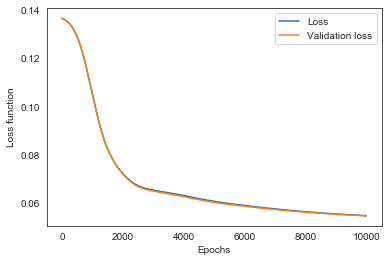

In [96]:
plot_history(autoencoder_5)

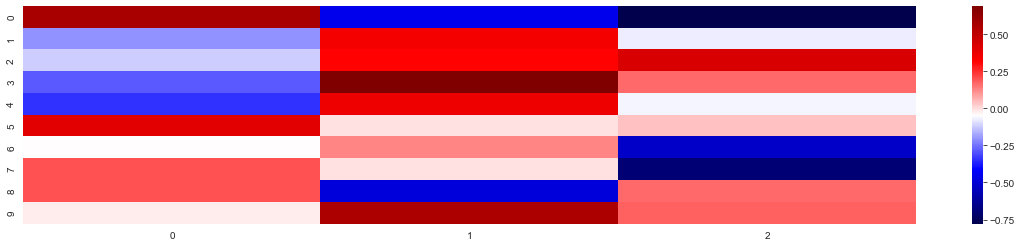

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

#get the weights of the hidden layer
weights=autoencoder_5.layers[5].get_weights()
#visualize the weights
plt.figure(figsize=(20,4))
sns.heatmap(data=weights[0], cmap='seismic')
#plt.gca().set_xticklabels(range(no_dim_features))
plt.show()

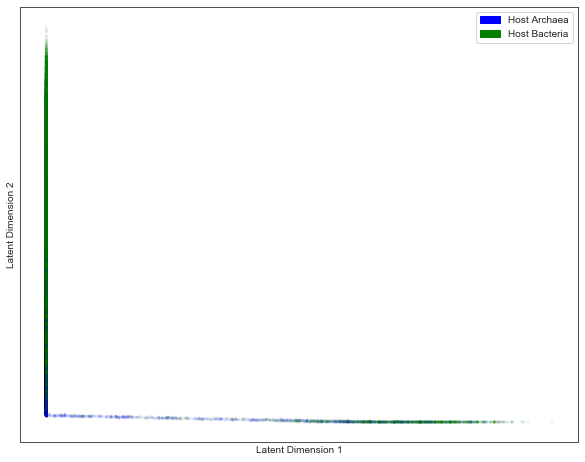

In [98]:
#encoder input into latent dimensions
x_enc_5 = encoder_5.predict(x_train, batch_size=256)
plot_encoded(x_enc_5, y_train)

No handles with labels found to put in legend.


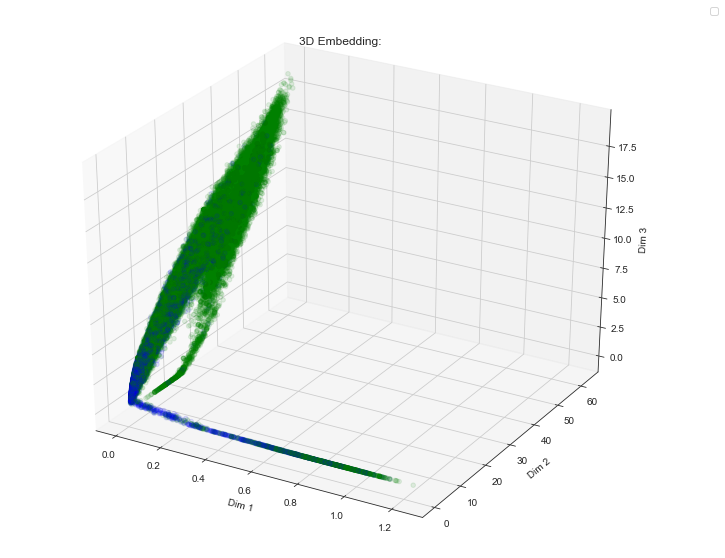

In [99]:
plot_encoded_3D(x_enc_5, y_train_og)

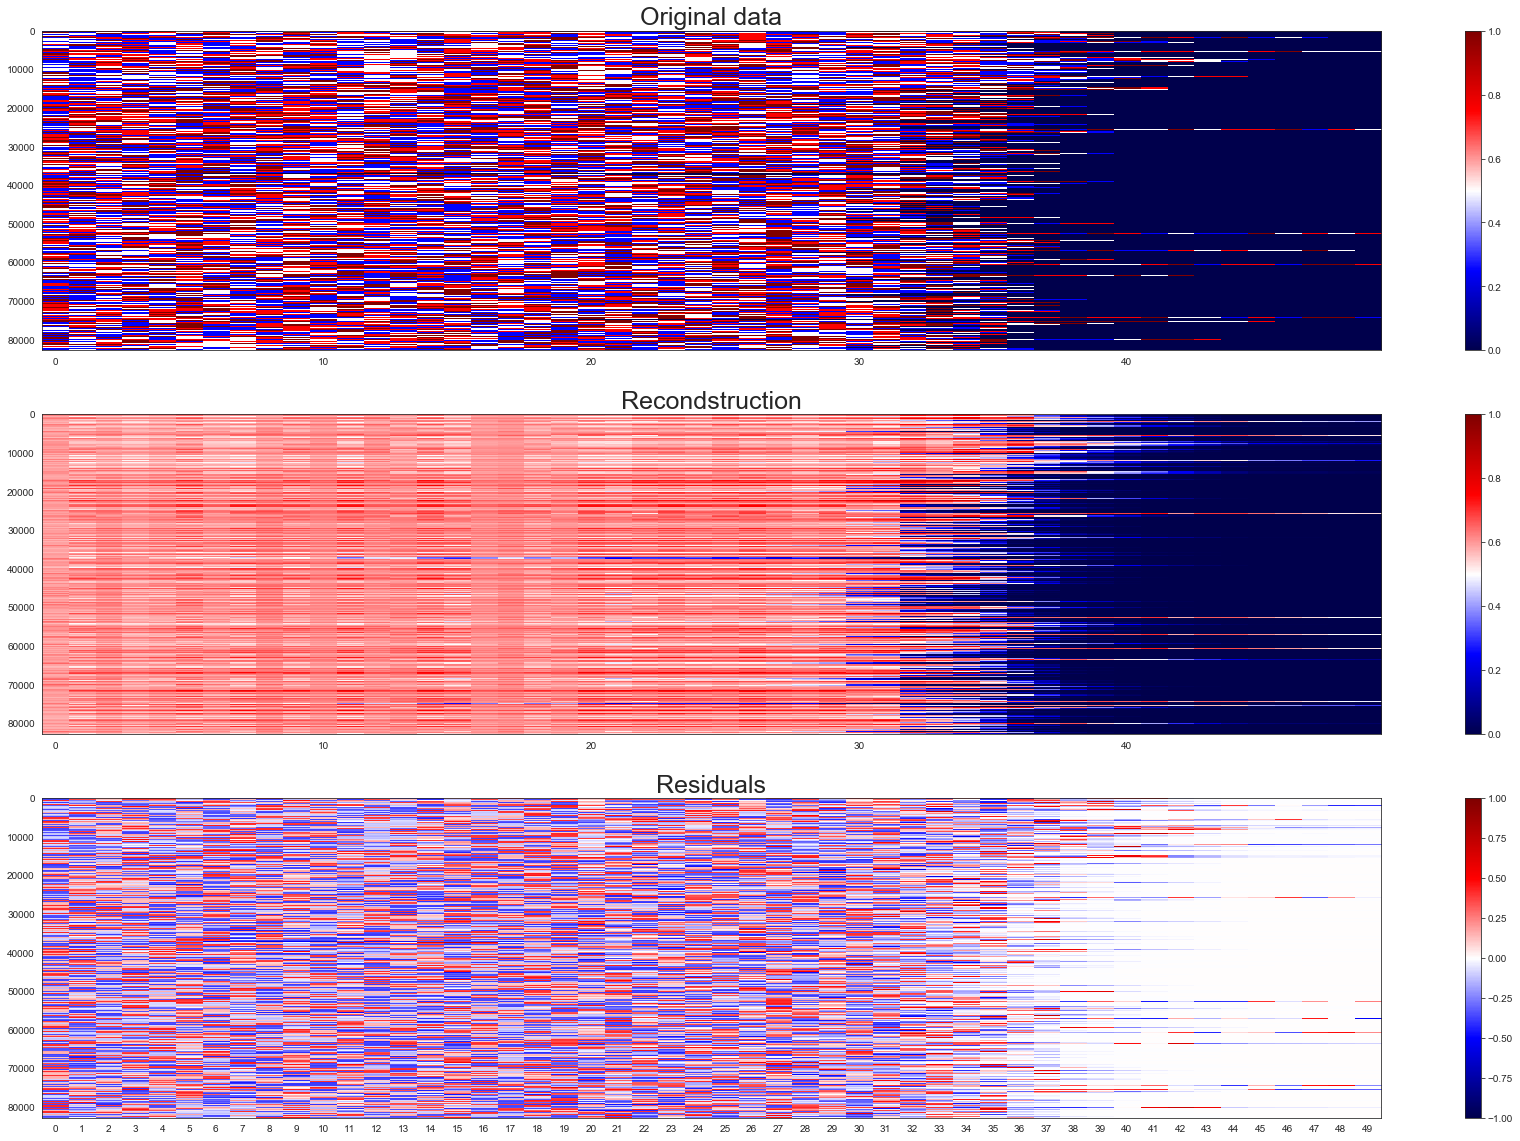

731384.1700076759


In [100]:
#reconstruct the data
data_dec_5 = autoencoder_5.predict(all_sequence_no_dim_norm)
plot_reconstruction(all_sequence_no_dim_norm, data_dec_5)

In [101]:
x_enc_4

array([[8.9372149e+00, 1.1618129e+01, 2.6829752e-01],
       [8.5053864e+00, 1.1204570e+01, 4.9449506e-01],
       [6.1922030e+00, 7.9494338e+00, 1.3328493e-03],
       ...,
       [3.3406836e-01, 3.8375251e+00, 1.7714847e+00],
       [0.0000000e+00, 4.3075037e+00, 2.2947762e+00],
       [4.4308662e+00, 7.9212399e+00, 1.8126022e+00]], dtype=float32)